In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 파일 경로
path = 'D:/dataset/playground_Sep2022'
# parse_dates : 데이터를 받을 때 ['date']부분을 datetime으로 빋는다
test = pd.read_csv(path + '/test.csv', parse_dates=["date"]).copy()
train = pd.read_csv(path + '/train.csv', parse_dates=["date"]).copy()
origin_train = train.copy()
sample_submission = pd.read_csv(path + '/sample_submission.csv').copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


In [3]:
test

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  
0            Kaggle Advanced Techniques  
1                Kaggle Getting Started  
2                    Kaggle Recipe Book  
3      Kaggle for Kids: One Smart Goose  
4            Kaggle Advanced Techniques  
...                                 ...  
17515  Kaggle for Kids: One Smart Goose  
17516        Kaggle Advanced Techniques  
17517            Kaggle Getting Started  
17518                Kaggle Recipe Book  
17519  Kaggle for Kids: One Smart Goose  

[17520 rows x 5 columns]

In [4]:
display(train.head())
display(test.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [5]:
# 수 확인
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count

def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel="");

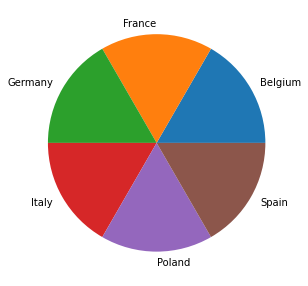

In [6]:
plot_and_display_valuecounts(train, 'country')

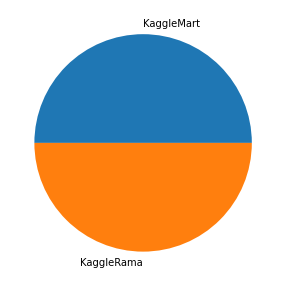

In [7]:
plot_and_display_valuecounts(train, 'store')

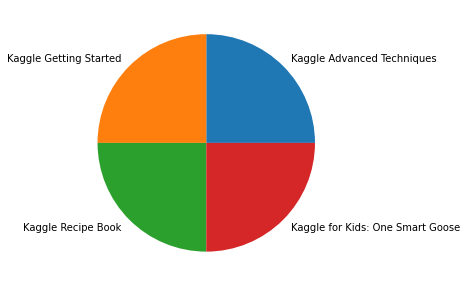

In [8]:
plot_and_display_valuecounts(train, 'product')

In [9]:
train.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

This gives us 48 univariate time series all of length 1461.
This data is equal amounts

In [10]:
# country, store, product 1주 간격으로 재정렬(num_sold 합)
weekly_df = train.groupby(['country', 'store','product', pd.Grouper(key = 'date', freq = 'W')])["num_sold"].sum().rename("num_sold").reset_index()

# country, store, product 1달 간격으로 재정렬(num_sold 합)
monthly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()
weekly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01       663
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-08      3362
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-15      2757
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-22      2863
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-29      2924

In [11]:
monthly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01     13345
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-02-01     12556
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-03-01     14137
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-04-01     14575
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-05-01     14338

In [12]:
def plot_all(df):
    f, axes = plt.subplots(2, 2, figsize = (20, 15), sharex = True, sharey = True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data = plot_df, x = 'date', y = 'num_sold', hue = 'country', style = 'store', ax = axes[n // 2, n% 2])
        axes[n // 2, n % 2].set_title("Product: "+str(prod))

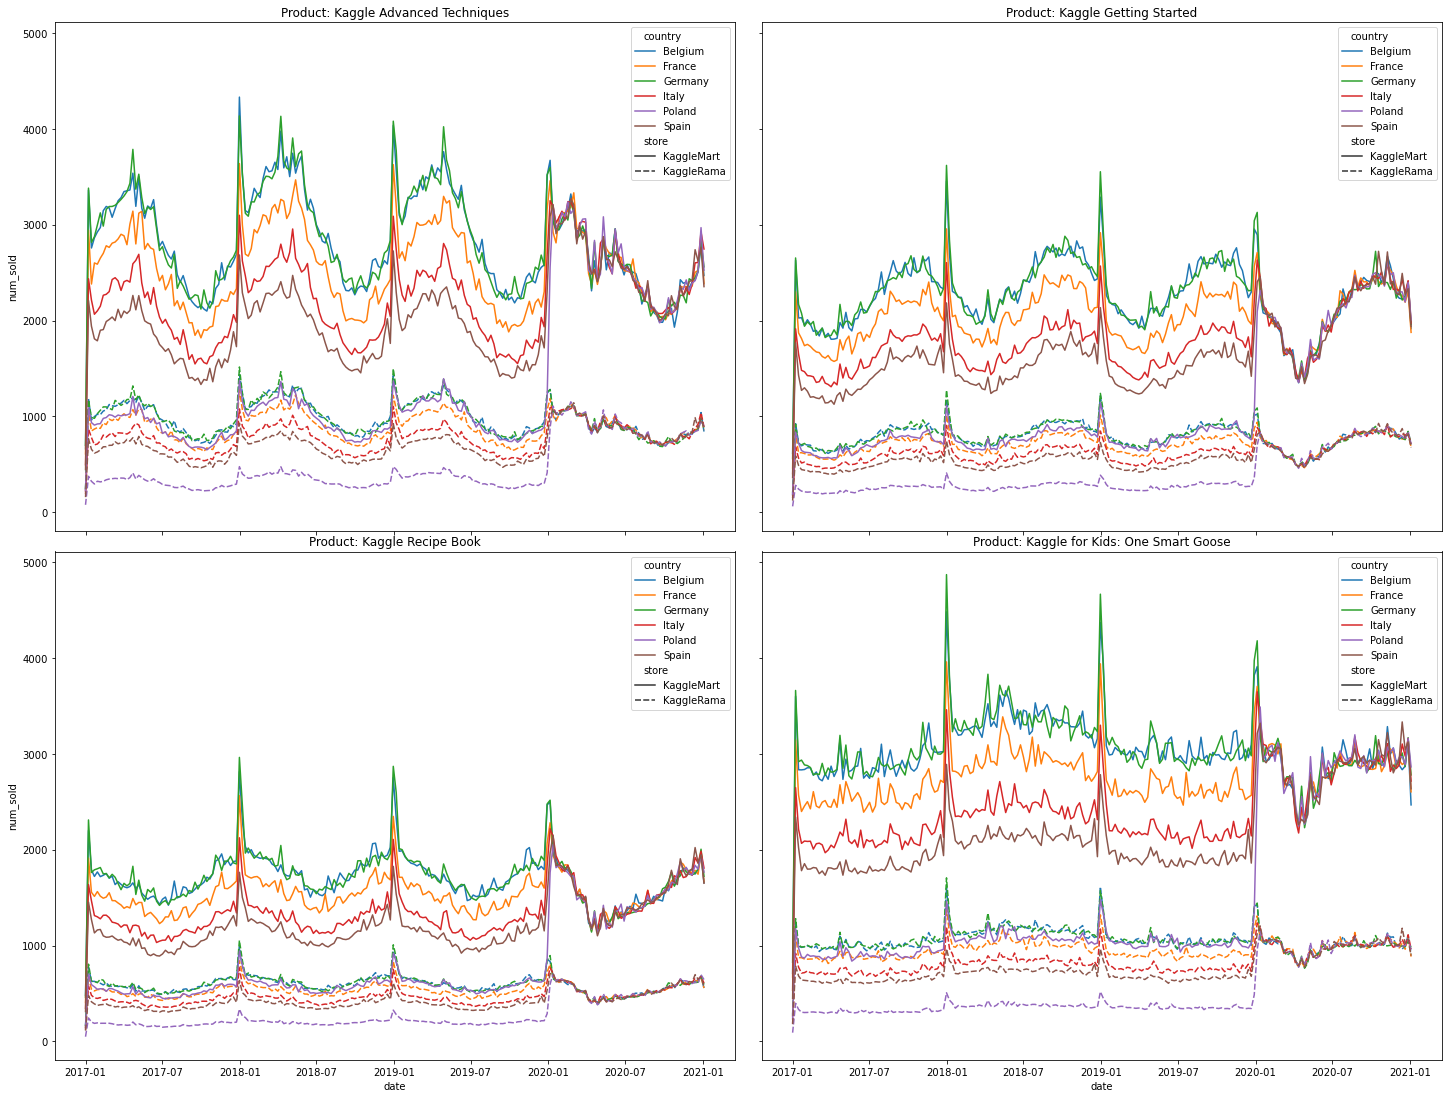

In [13]:
plot_all(weekly_df)

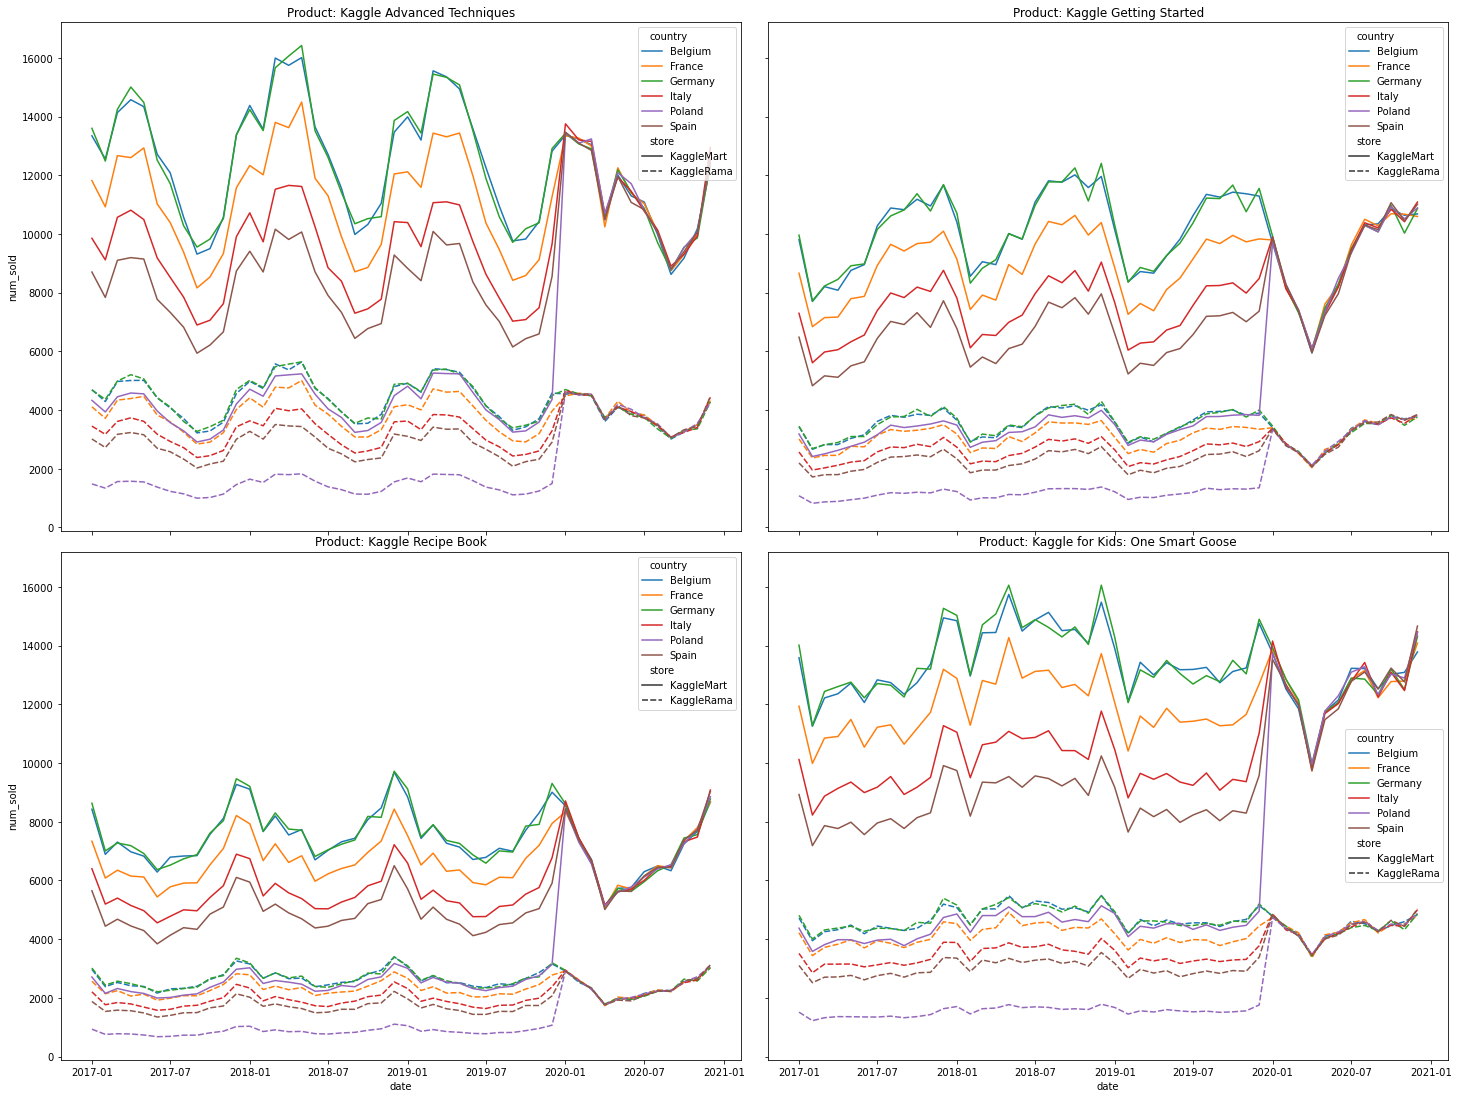

In [14]:
plot_all(monthly_df)

In [15]:
def make_radio(df, index):
    rate = str(index) + '_weights'
    radio = (df.groupby(["date",index])["num_sold"].sum() / df.groupby(["date"])["num_sold"].sum()).reset_index()
    weights = (df.groupby(index)['num_sold'].sum() / df['num_sold'].sum()).rename(rate)
    return radio, weights

In [16]:
store_ratio_over_time, store_weights = make_radio(train, "store")
store_ratio_over_time

date       store  num_sold
0    2017-01-01  KaggleMart  0.736972
1    2017-01-01  KaggleRama  0.263028
2    2017-01-02  KaggleMart  0.739679
3    2017-01-02  KaggleRama  0.260321
4    2017-01-03  KaggleMart  0.741823
...         ...         ...       ...
2917 2020-12-29  KaggleRama  0.263032
2918 2020-12-30  KaggleMart  0.741631
2919 2020-12-30  KaggleRama  0.258369
2920 2020-12-31  KaggleMart  0.738594
2921 2020-12-31  KaggleRama  0.261406

[2922 rows x 3 columns]

In [17]:
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: store_weights, dtype: float64

In [18]:
store_ratio_over_time['num_sold']

0       0.736972
1       0.263028
2       0.739679
3       0.260321
4       0.741823
          ...   
2917    0.263032
2918    0.741631
2919    0.258369
2920    0.738594
2921    0.261406
Name: num_sold, Length: 2922, dtype: float64

In [19]:
store_ratio_over_time = store_ratio_over_time.merge(store_weights, on = ['store'], how = 'left')
store_ratio_over_time

date       store  num_sold  store_weights
0    2017-01-01  KaggleMart  0.736972       0.742515
1    2017-01-01  KaggleRama  0.263028       0.257485
2    2017-01-02  KaggleMart  0.739679       0.742515
3    2017-01-02  KaggleRama  0.260321       0.257485
4    2017-01-03  KaggleMart  0.741823       0.742515
...         ...         ...       ...            ...
2917 2020-12-29  KaggleRama  0.263032       0.257485
2918 2020-12-30  KaggleMart  0.741631       0.742515
2919 2020-12-30  KaggleRama  0.258369       0.257485
2920 2020-12-31  KaggleMart  0.738594       0.742515
2921 2020-12-31  KaggleRama  0.261406       0.257485

[2922 rows x 4 columns]

In [20]:
store_ratio_over_time['minus'] = store_ratio_over_time['num_sold'] - store_ratio_over_time['store_weights']
store_ratio_over_time

date       store  num_sold  store_weights     minus
0    2017-01-01  KaggleMart  0.736972       0.742515 -0.005542
1    2017-01-01  KaggleRama  0.263028       0.257485  0.005542
2    2017-01-02  KaggleMart  0.739679       0.742515 -0.002836
3    2017-01-02  KaggleRama  0.260321       0.257485  0.002836
4    2017-01-03  KaggleMart  0.741823       0.742515 -0.000692
...         ...         ...       ...            ...       ...
2917 2020-12-29  KaggleRama  0.263032       0.257485  0.005547
2918 2020-12-30  KaggleMart  0.741631       0.742515 -0.000884
2919 2020-12-30  KaggleRama  0.258369       0.257485  0.000884
2920 2020-12-31  KaggleMart  0.738594       0.742515 -0.003921
2921 2020-12-31  KaggleRama  0.261406       0.257485  0.003921

[2922 rows x 5 columns]

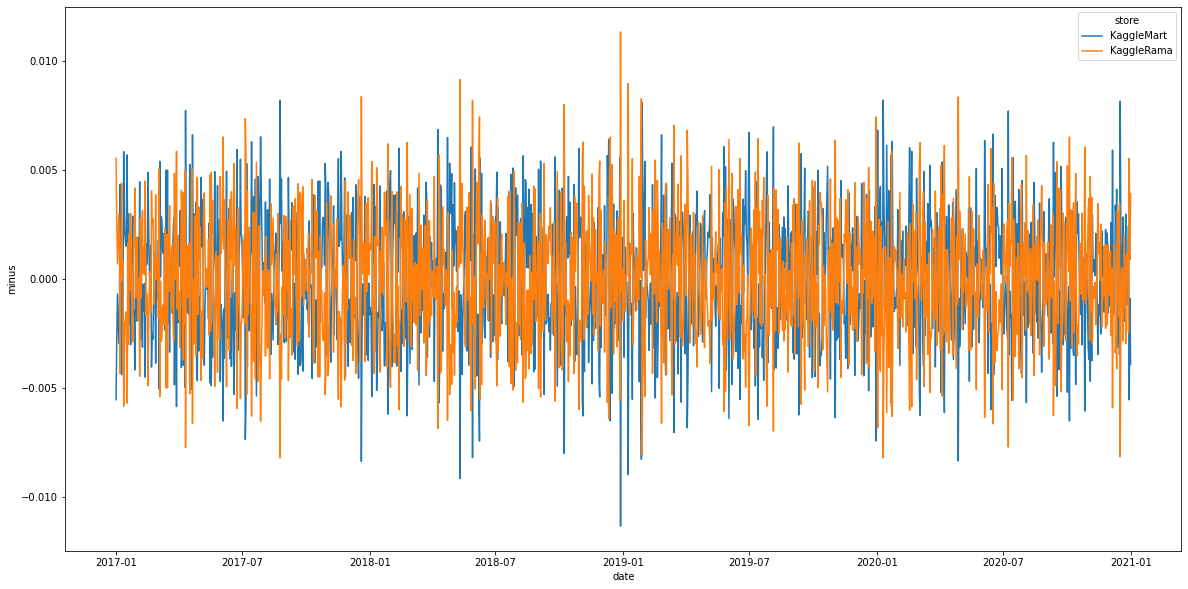

In [21]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(data = store_ratio_over_time, x = 'date', y = 'minus', hue = 'store')
ax.set_label("Proportion of sales");

In [22]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = store_weights.loc["KaggleMart"] / store_weights
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

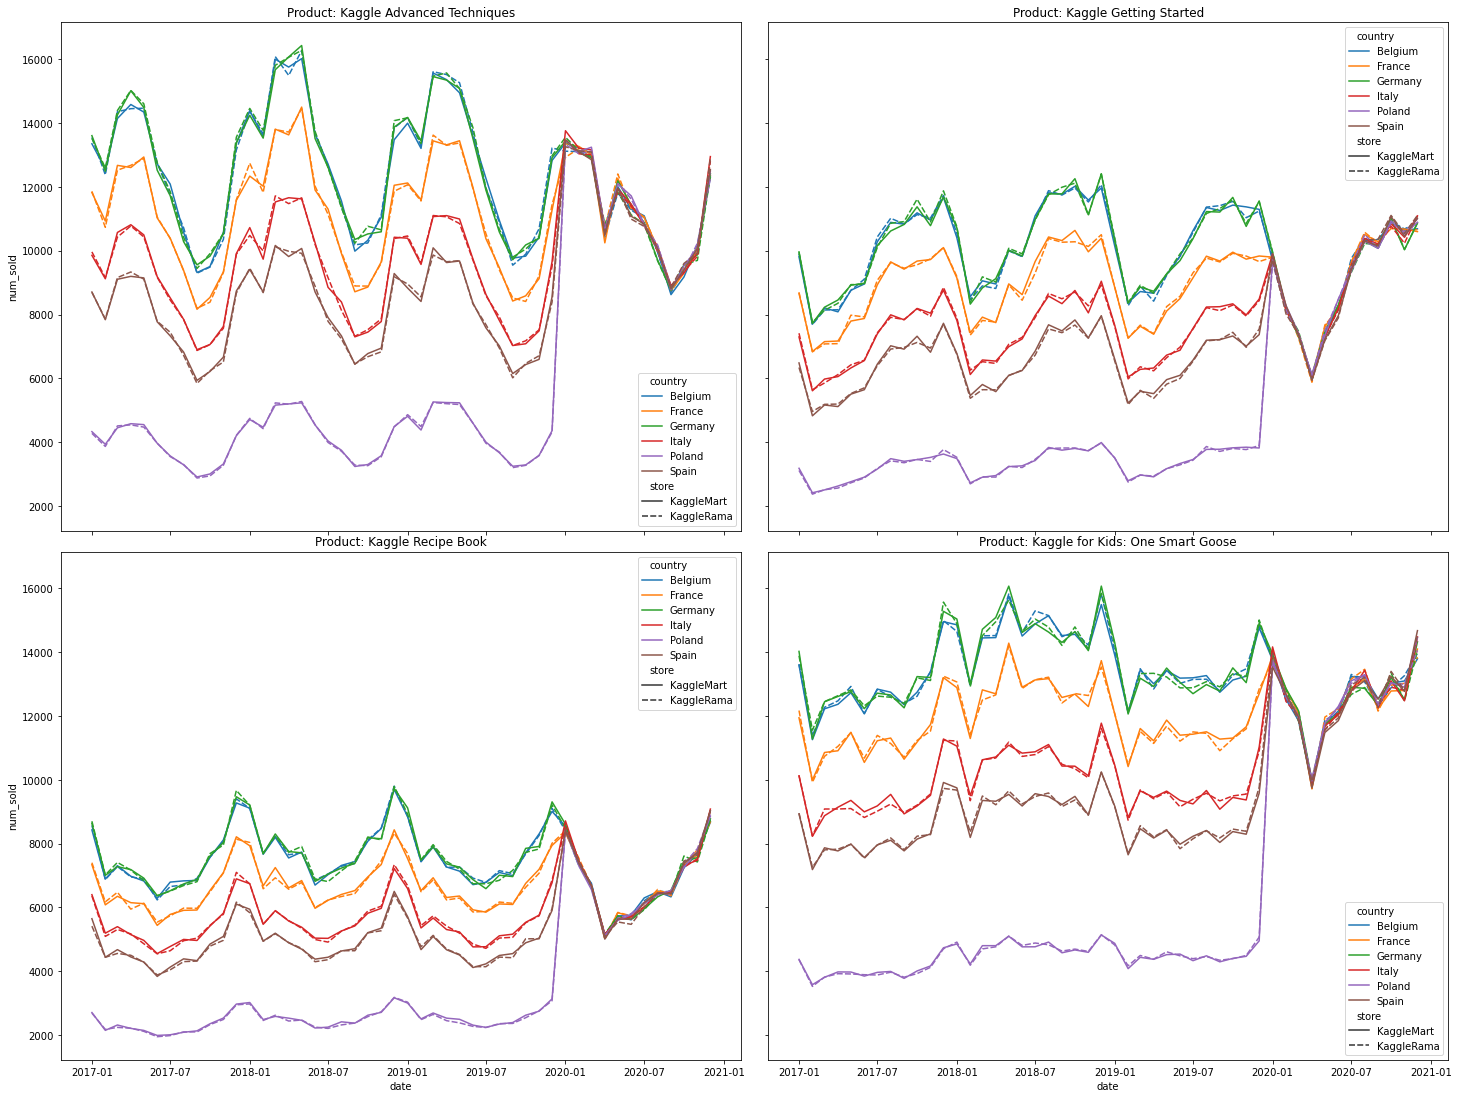

In [23]:
plot_adjusted_store(monthly_df)

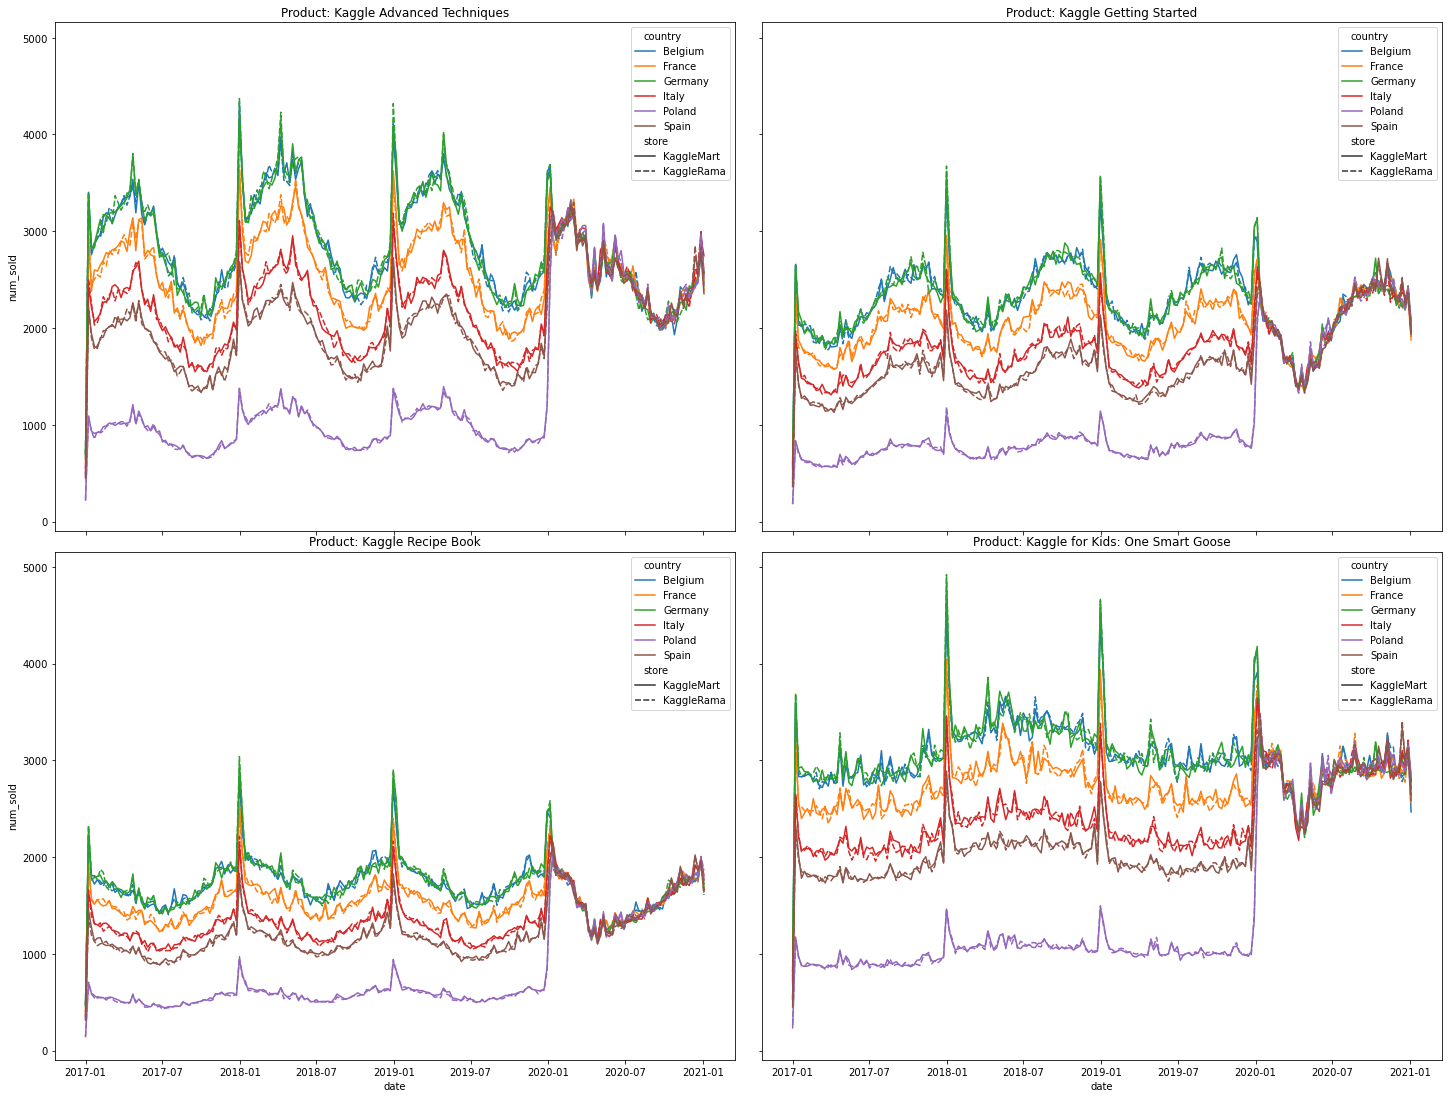

In [24]:
plot_adjusted_store(weekly_df)

In [25]:
country_ratio_over_time, country_weights = make_radio(train, "country")
country_ratio_over_time

date  country  num_sold
0    2017-01-01  Belgium  0.216258
1    2017-01-01   France  0.191441
2    2017-01-01  Germany  0.223880
3    2017-01-01    Italy  0.158351
4    2017-01-01   Poland  0.069958
...         ...      ...       ...
8761 2020-12-31   France  0.159591
8762 2020-12-31  Germany  0.172803
8763 2020-12-31    Italy  0.178028
8764 2020-12-31   Poland  0.172744
8765 2020-12-31    Spain  0.159474

[8766 rows x 3 columns]

In [26]:
country_weights

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: country_weights, dtype: float64

In [27]:
country_weights = (train.loc[train["date"] < "2020-01-01"].groupby('country')['num_sold'].sum() / train.loc[train["date"] < "2020-01-01", 'num_sold'].sum()).rename('country_weights')
country_weights

country
Belgium    0.218930
France     0.191360
Germany    0.219586
Italy      0.159383
Poland     0.071348
Spain      0.139393
Name: country_weights, dtype: float64

In [28]:
country_weights_after_2020 = country_weights.copy()
country_weights_after_2020 = (train.loc[train["date"] >= "2020-01-01"].groupby('country')['num_sold'].sum() / train.loc[train["date"] >= "2020-01-01", 'num_sold'].sum()).rename('country_weights')
country_weights_after_2020

country
Belgium    0.166528
France     0.166696
Germany    0.166257
Italy      0.167007
Poland     0.167162
Spain      0.166349
Name: country_weights, dtype: float64

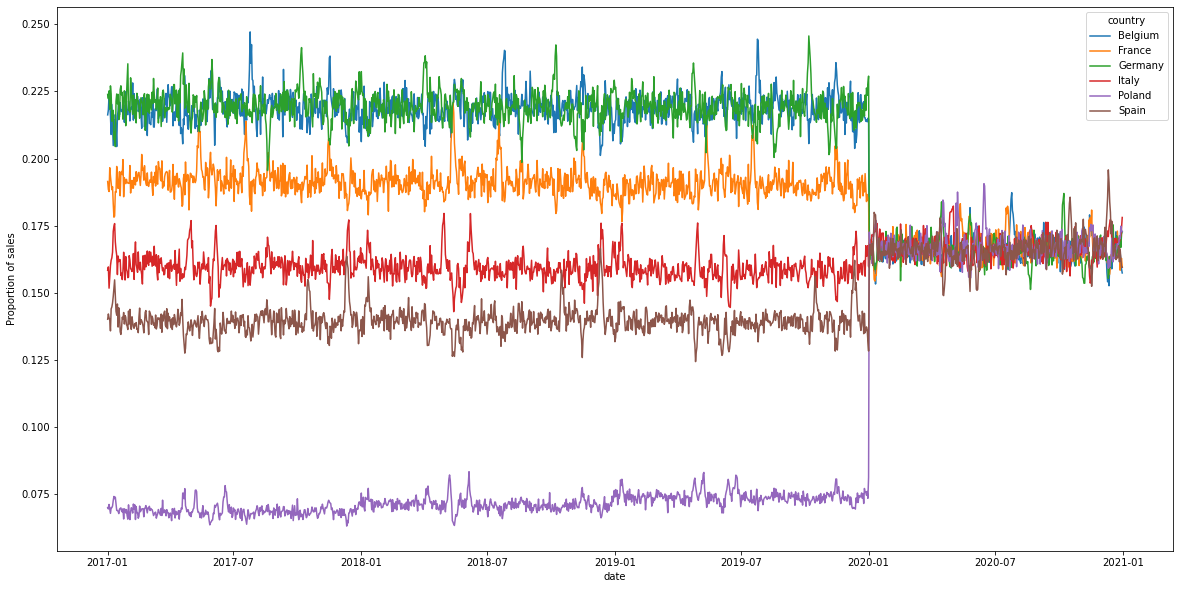

In [29]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
ax.set_ylabel("Proportion of sales");

In [30]:
def plot_adjust_country(df):
    new_df = df.copy()
    
    weights = country_weights.loc["Belgium"] / country_weights
    
    for country in weights.index:
#         2020-01-01까지만 weights를 곱하는 이유 : 2020-01-01 이후는 모든 나라에서 파는 수가 비슷하기 때문에
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  weights[country]
    #plot_country_product(new_df)
    plot_all(new_df)

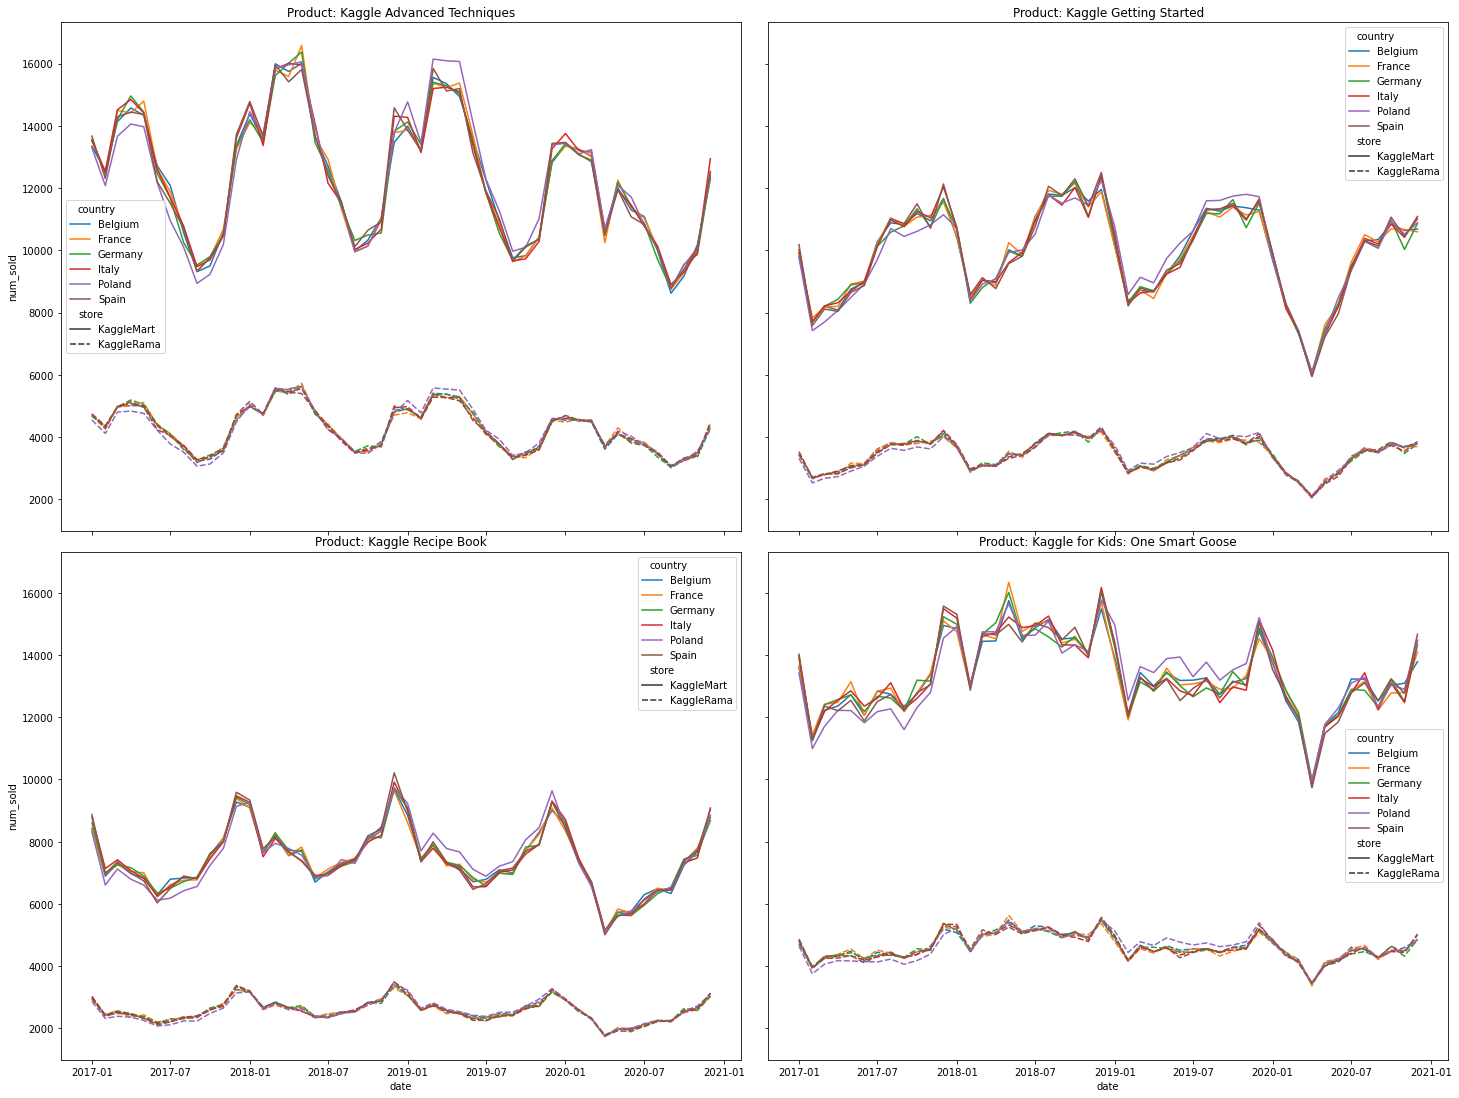

In [31]:
plot_adjust_country(monthly_df)

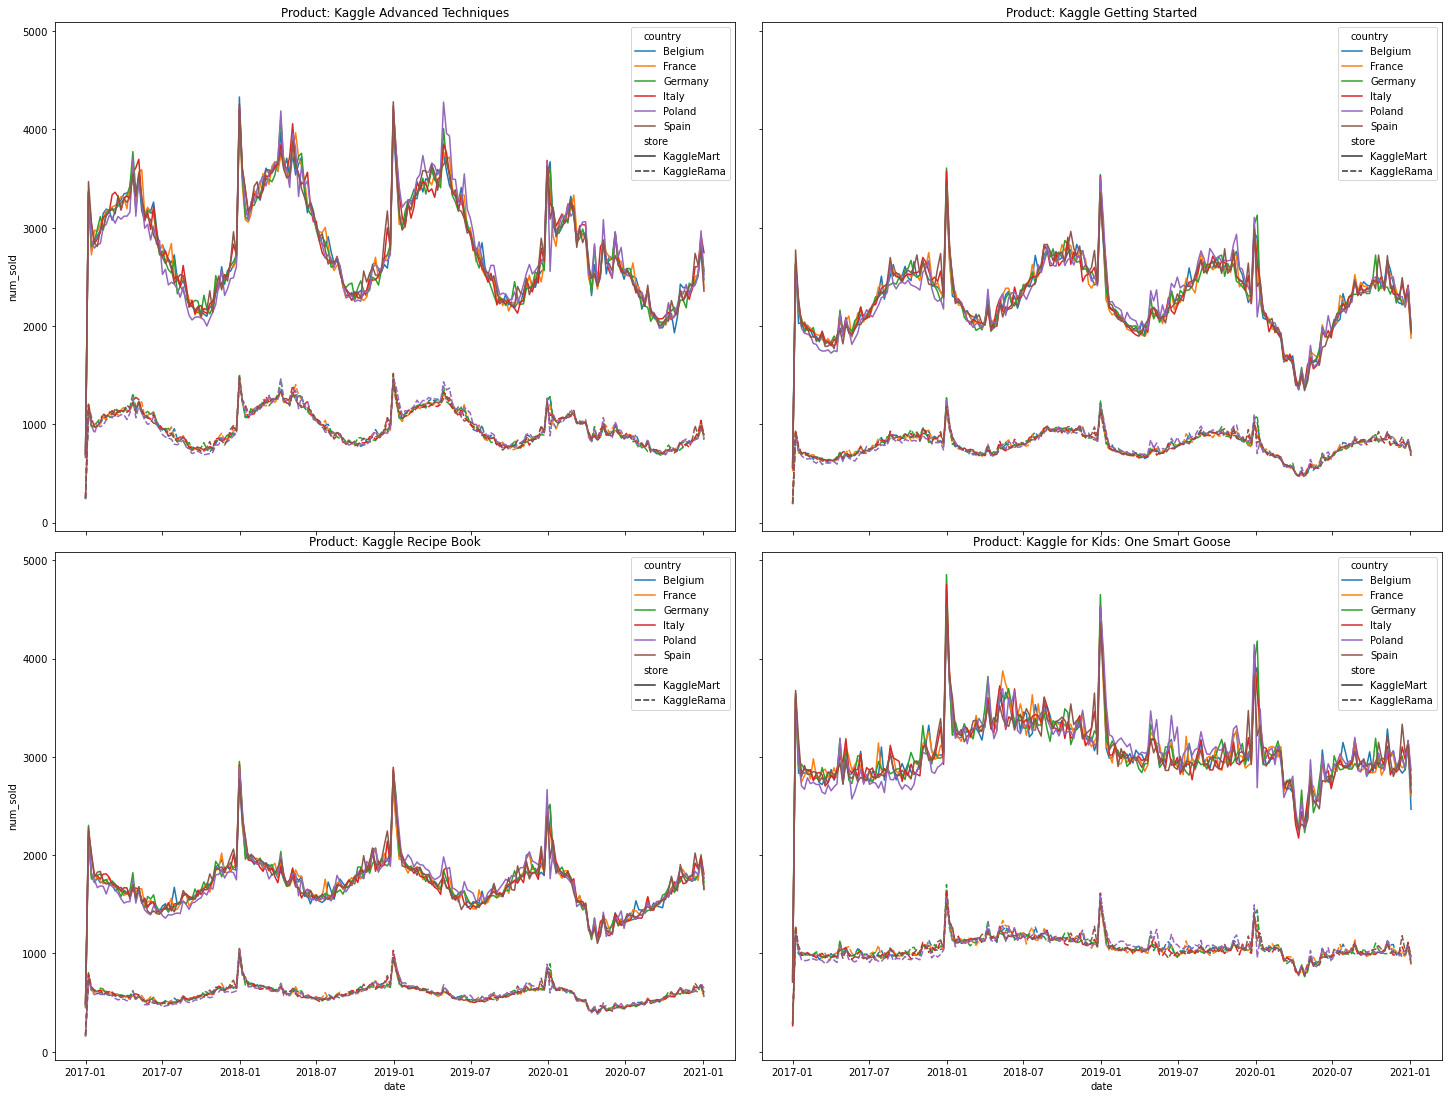

In [32]:
plot_adjust_country(weekly_df)

In [33]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df

date                           product  num_sold
0    2017-01-01        Kaggle Advanced Techniques      4267
1    2017-01-01            Kaggle Getting Started      3492
2    2017-01-01                Kaggle Recipe Book      2900
3    2017-01-01  Kaggle for Kids: One Smart Goose      4693
4    2017-01-02        Kaggle Advanced Techniques      3242
...         ...                               ...       ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose      5699
5840 2020-12-31        Kaggle Advanced Techniques      4968
5841 2020-12-31            Kaggle Getting Started      3780
5842 2020-12-31                Kaggle Recipe Book      3301
5843 2020-12-31  Kaggle for Kids: One Smart Goose      4982

[5844 rows x 3 columns]

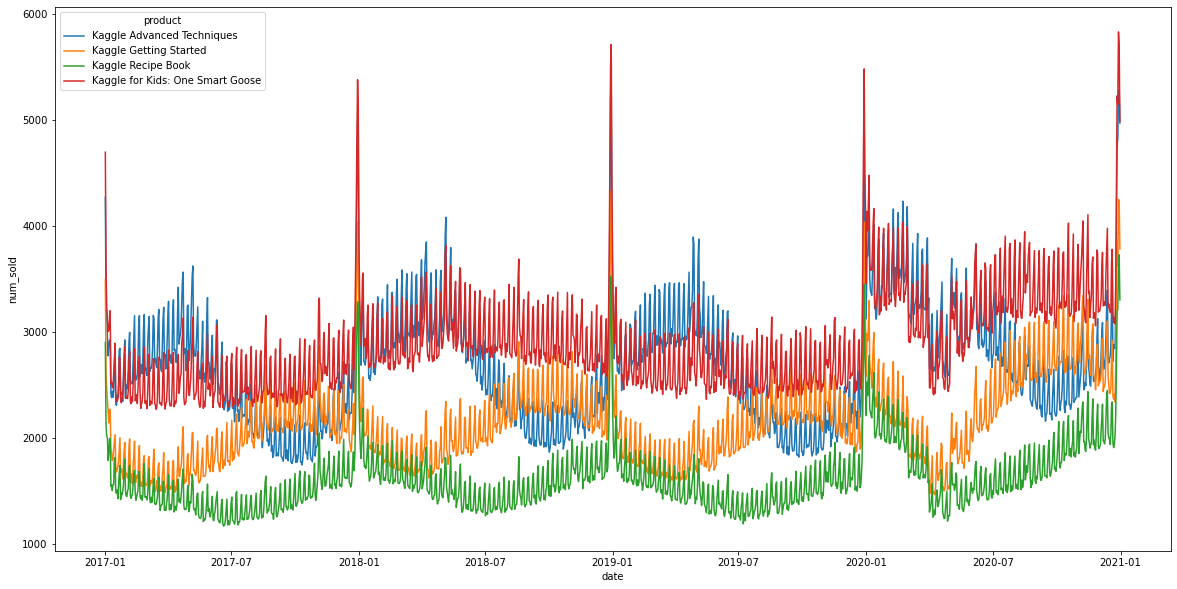

In [34]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

In [35]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_weights = (product_df.groupby("product")['num_sold'].sum() / product_df['num_sold'].sum()).rename('product_weights')
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("product_radio").reset_index()
product_ratio_df

date                           product  product_radio
0    2017-01-01        Kaggle Advanced Techniques       0.277944
1    2017-01-01            Kaggle Getting Started       0.227462
2    2017-01-01                Kaggle Recipe Book       0.188900
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693
4    2017-01-02        Kaggle Advanced Techniques       0.280014
...         ...                               ...            ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929
5840 2020-12-31        Kaggle Advanced Techniques       0.291703
5841 2020-12-31            Kaggle Getting Started       0.221948
5842 2020-12-31                Kaggle Recipe Book       0.193823
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525

[5844 rows x 3 columns]

In [36]:
product_weights

product
Kaggle Advanced Techniques          0.287246
Kaggle Getting Started              0.230220
Kaggle Recipe Book                  0.172455
Kaggle for Kids: One Smart Goose    0.310079
Name: product_weights, dtype: float64

In [37]:
product_ratio_df = product_ratio_df.merge(product_weights, on = ['product'], how = 'left')
# product_ratio_df['minus'] = product_ratio_df['product_radio'] - product_ratio_df['num_sold']
product_ratio_df

date                           product  product_radio  \
0    2017-01-01        Kaggle Advanced Techniques       0.277944   
1    2017-01-01            Kaggle Getting Started       0.227462   
2    2017-01-01                Kaggle Recipe Book       0.188900   
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693   
4    2017-01-02        Kaggle Advanced Techniques       0.280014   
...         ...                               ...            ...   
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929   
5840 2020-12-31        Kaggle Advanced Techniques       0.291703   
5841 2020-12-31            Kaggle Getting Started       0.221948   
5842 2020-12-31                Kaggle Recipe Book       0.193823   
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525   

      product_weights  
0            0.287246  
1            0.230220  
2            0.172455  
3            0.310079  
4            0.287246  
...               ...  
5839         0.310079  
5840         0.287246  
5841         0.230220  
5842         0.172455  
5843         0.310079  

[5844 rows x 4 columns]

In [38]:
product_ratio_df['minus'] = product_ratio_df['product_radio'] - product_ratio_df['product_weights']
product_ratio_df

date                           product  product_radio  \
0    2017-01-01        Kaggle Advanced Techniques       0.277944   
1    2017-01-01            Kaggle Getting Started       0.227462   
2    2017-01-01                Kaggle Recipe Book       0.188900   
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693   
4    2017-01-02        Kaggle Advanced Techniques       0.280014   
...         ...                               ...            ...   
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929   
5840 2020-12-31        Kaggle Advanced Techniques       0.291703   
5841 2020-12-31            Kaggle Getting Started       0.221948   
5842 2020-12-31                Kaggle Recipe Book       0.193823   
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525   

      product_weights     minus  
0            0.287246 -0.009301  
1            0.230220 -0.002758  
2            0.172455  0.016445  
3            0.310079 -0.004386  
4            0.287246 -0.007232  
...               ...       ...  
5839         0.310079 -0.009150  
5840         0.287246  0.004458  
5841         0.230220 -0.008272  
5842         0.172455  0.021368  
5843         0.310079 -0.017553  

[5844 rows x 5 columns]

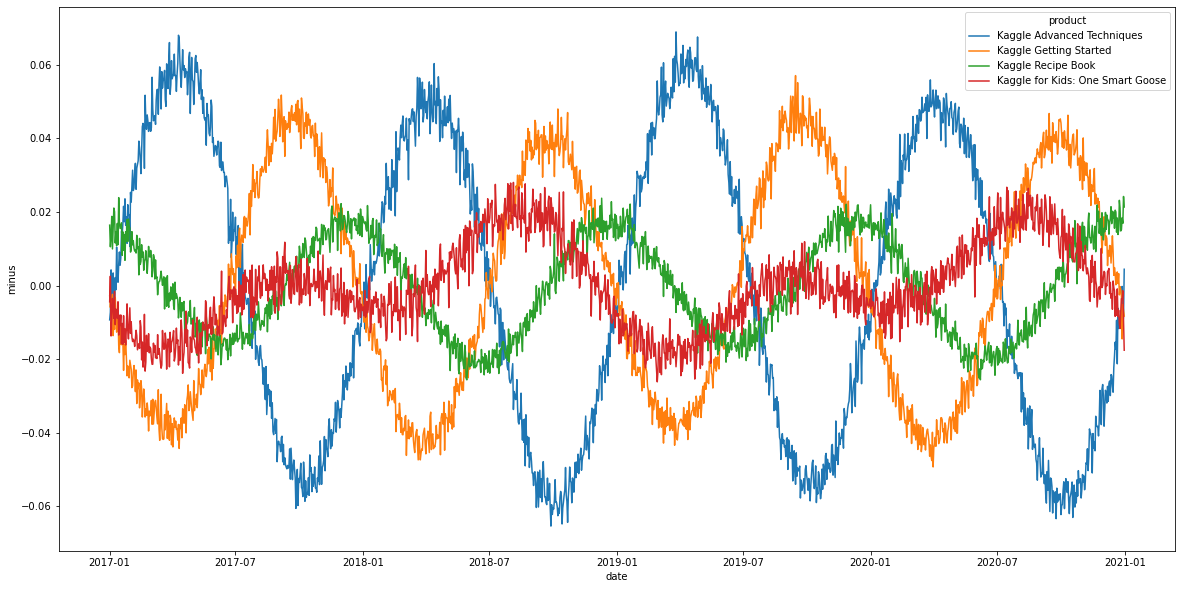

In [39]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="minus", hue="product");

In [876]:
test = pd.read_csv(path + '/test.csv', parse_dates=["date"]).copy()
train = pd.read_csv(path + '/train.csv', parse_dates=["date"]).copy()
train_sold = train.copy()
test_sold = test.copy()

In [877]:
train_product_radio = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_weights = (train_product_radio.groupby("product")['num_sold'].sum() / train_product_radio['num_sold'].sum()).rename('product_weights')
train_product_radio = train_product_radio.pivot(index="date", columns="product", values="num_sold")
# product / 하루동안 팔린 책
train_product_radio = train_product_radio.apply(lambda x: x/x.sum(),axis=1)
train_product_radio = train_product_radio.stack().rename("product_radio").reset_index()
train_product_radio

date                           product  product_radio
0    2017-01-01        Kaggle Advanced Techniques       0.277944
1    2017-01-01            Kaggle Getting Started       0.227462
2    2017-01-01                Kaggle Recipe Book       0.188900
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693
4    2017-01-02        Kaggle Advanced Techniques       0.280014
...         ...                               ...            ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929
5840 2020-12-31        Kaggle Advanced Techniques       0.291703
5841 2020-12-31            Kaggle Getting Started       0.221948
5842 2020-12-31                Kaggle Recipe Book       0.193823
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525

[5844 rows x 3 columns]

In [878]:
train_product_radio.head(10)

date                           product  product_radio
0 2017-01-01        Kaggle Advanced Techniques       0.277944
1 2017-01-01            Kaggle Getting Started       0.227462
2 2017-01-01                Kaggle Recipe Book       0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose       0.305693
4 2017-01-02        Kaggle Advanced Techniques       0.280014
5 2017-01-02            Kaggle Getting Started       0.224305
6 2017-01-02                Kaggle Recipe Book       0.183020
7 2017-01-02  Kaggle for Kids: One Smart Goose       0.312662
8 2017-01-03        Kaggle Advanced Techniques       0.291529
9 2017-01-03            Kaggle Getting Started       0.226295

In [879]:
product_weights

product
Kaggle Advanced Techniques          0.287246
Kaggle Getting Started              0.230220
Kaggle Recipe Book                  0.172455
Kaggle for Kids: One Smart Goose    0.310079
Name: product_weights, dtype: float64

In [880]:
# weights = product_weights.loc["Kaggle Advanced Techniques"] / product_weights
# for product in weights.index:
#     train_product_radio.loc[train_product_radio["product"] == product, "product_radio"] = train_product_radio.loc[train_product_radio["product"] == product, "product_radio"] * weights[product]

In [881]:
train_product_radio

date                           product  product_radio
0    2017-01-01        Kaggle Advanced Techniques       0.277944
1    2017-01-01            Kaggle Getting Started       0.227462
2    2017-01-01                Kaggle Recipe Book       0.188900
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693
4    2017-01-02        Kaggle Advanced Techniques       0.280014
...         ...                               ...            ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929
5840 2020-12-31        Kaggle Advanced Techniques       0.291703
5841 2020-12-31            Kaggle Getting Started       0.221948
5842 2020-12-31                Kaggle Recipe Book       0.193823
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525

[5844 rows x 3 columns]

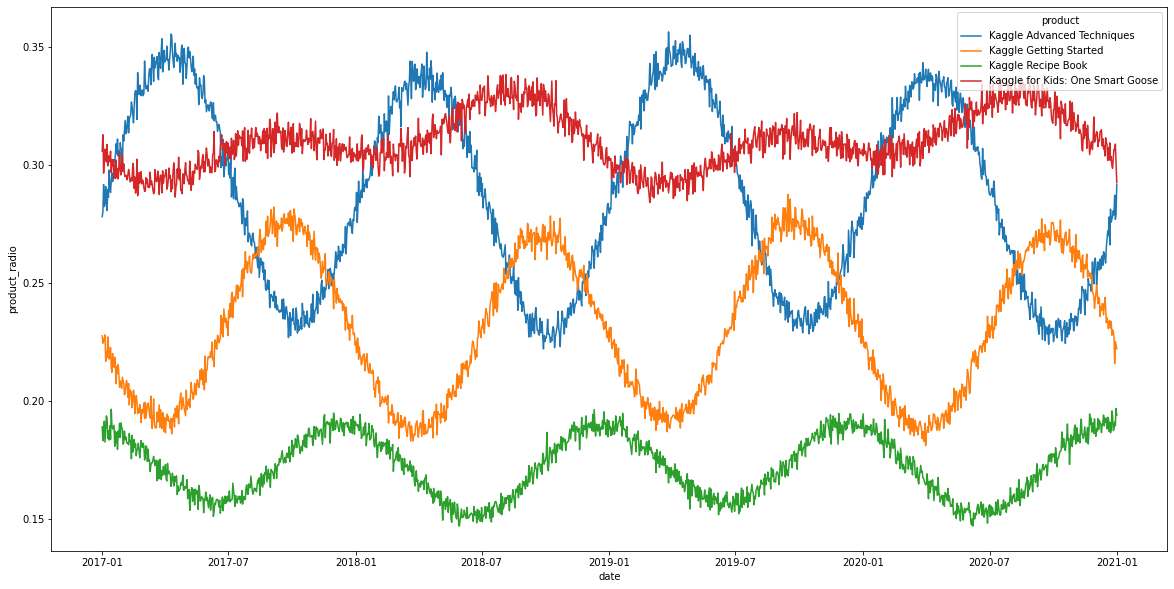

In [882]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_product_radio, x="date", y="product_radio", hue="product");

In [883]:
from catboost import CatBoostRegressor
X_train_product_radio = train_product_radio.drop(['product_radio'], axis = 1)
y_train_product_radio = train_product_radio['product_radio'].copy()
categorical_features_names = ['product']

model_product_radio = CatBoostRegressor(n_estimators=500, random_state = 42, cat_features = categorical_features_names)
model_product_radio.fit(X_train_product_radio, y_train_product_radio)

Learning rate set to 0.095073
0:	learn: 0.0549919	total: 15.8ms	remaining: 7.88s
1:	learn: 0.0510911	total: 36.9ms	remaining: 9.18s
2:	learn: 0.0473518	total: 79.2ms	remaining: 13.1s
3:	learn: 0.0439403	total: 149ms	remaining: 18.4s
4:	learn: 0.0411869	total: 198ms	remaining: 19.6s
5:	learn: 0.0384494	total: 219ms	remaining: 18.1s
6:	learn: 0.0363826	total: 260ms	remaining: 18.3s
7:	learn: 0.0344560	total: 298ms	remaining: 18.3s
8:	learn: 0.0325351	total: 319ms	remaining: 17.4s
9:	learn: 0.0309447	total: 362ms	remaining: 17.8s
10:	learn: 0.0296725	total: 381ms	remaining: 16.9s
11:	learn: 0.0285472	total: 427ms	remaining: 17.4s
12:	learn: 0.0275836	total: 473ms	remaining: 17.7s
13:	learn: 0.0265704	total: 518ms	remaining: 18s
14:	learn: 0.0255589	total: 567ms	remaining: 18.3s
15:	learn: 0.0246547	total: 615ms	remaining: 18.6s
16:	learn: 0.0238640	total: 681ms	remaining: 19.4s
17:	learn: 0.0231962	total: 739ms	remaining: 19.8s
18:	learn: 0.0227860	total: 799ms	remaining: 20.2s
19:	learn:

162:	learn: 0.0068311	total: 6.28s	remaining: 13s
163:	learn: 0.0068050	total: 6.31s	remaining: 12.9s
164:	learn: 0.0067853	total: 6.34s	remaining: 12.9s
165:	learn: 0.0067591	total: 6.39s	remaining: 12.9s
166:	learn: 0.0067448	total: 6.42s	remaining: 12.8s
167:	learn: 0.0067248	total: 6.43s	remaining: 12.7s
168:	learn: 0.0067024	total: 6.48s	remaining: 12.7s
169:	learn: 0.0066863	total: 6.54s	remaining: 12.7s
170:	learn: 0.0066745	total: 6.59s	remaining: 12.7s
171:	learn: 0.0066519	total: 6.61s	remaining: 12.6s
172:	learn: 0.0066307	total: 6.64s	remaining: 12.5s
173:	learn: 0.0066159	total: 6.68s	remaining: 12.5s
174:	learn: 0.0066136	total: 6.71s	remaining: 12.5s
175:	learn: 0.0065931	total: 6.76s	remaining: 12.5s
176:	learn: 0.0065864	total: 6.79s	remaining: 12.4s
177:	learn: 0.0065635	total: 6.82s	remaining: 12.3s
178:	learn: 0.0065435	total: 6.86s	remaining: 12.3s
179:	learn: 0.0065214	total: 6.89s	remaining: 12.2s
180:	learn: 0.0064984	total: 6.96s	remaining: 12.3s
181:	learn: 0.

322:	learn: 0.0049173	total: 11.8s	remaining: 6.49s
323:	learn: 0.0049016	total: 11.9s	remaining: 6.46s
324:	learn: 0.0048973	total: 11.9s	remaining: 6.43s
325:	learn: 0.0048968	total: 12s	remaining: 6.39s
326:	learn: 0.0048948	total: 12s	remaining: 6.34s
327:	learn: 0.0048874	total: 12s	remaining: 6.3s
328:	learn: 0.0048813	total: 12.1s	remaining: 6.27s
329:	learn: 0.0048719	total: 12.1s	remaining: 6.23s
330:	learn: 0.0048628	total: 12.1s	remaining: 6.19s
331:	learn: 0.0048620	total: 12.2s	remaining: 6.15s
332:	learn: 0.0048603	total: 12.2s	remaining: 6.11s
333:	learn: 0.0048597	total: 12.2s	remaining: 6.07s
334:	learn: 0.0048436	total: 12.2s	remaining: 6.03s
335:	learn: 0.0048293	total: 12.3s	remaining: 5.99s
336:	learn: 0.0048276	total: 12.3s	remaining: 5.95s
337:	learn: 0.0048197	total: 12.4s	remaining: 5.92s
338:	learn: 0.0048080	total: 12.4s	remaining: 5.88s
339:	learn: 0.0048033	total: 12.4s	remaining: 5.85s
340:	learn: 0.0048021	total: 12.5s	remaining: 5.82s
341:	learn: 0.00479

482:	learn: 0.0042728	total: 17.6s	remaining: 618ms
483:	learn: 0.0042723	total: 17.6s	remaining: 582ms
484:	learn: 0.0042708	total: 17.6s	remaining: 545ms
485:	learn: 0.0042701	total: 17.7s	remaining: 509ms
486:	learn: 0.0042567	total: 17.7s	remaining: 472ms
487:	learn: 0.0042566	total: 17.7s	remaining: 436ms
488:	learn: 0.0042551	total: 17.8s	remaining: 399ms
489:	learn: 0.0042537	total: 17.8s	remaining: 363ms
490:	learn: 0.0042514	total: 17.9s	remaining: 327ms
491:	learn: 0.0042509	total: 17.9s	remaining: 291ms
492:	learn: 0.0042499	total: 17.9s	remaining: 255ms
493:	learn: 0.0042487	total: 17.9s	remaining: 218ms
494:	learn: 0.0042482	total: 18s	remaining: 182ms
495:	learn: 0.0042480	total: 18s	remaining: 145ms
496:	learn: 0.0042412	total: 18.1s	remaining: 109ms
497:	learn: 0.0042391	total: 18.1s	remaining: 72.7ms
498:	learn: 0.0042380	total: 18.1s	remaining: 36.3ms
499:	learn: 0.0042367	total: 18.2s	remaining: 0us


In [884]:
test_product_radio = test.groupby(['date', 'product']).sum().reset_index()
test_product_radio = test_product_radio.drop(['row_id'], axis = 1)
test_product_radio

date                           product
0    2021-01-01        Kaggle Advanced Techniques
1    2021-01-01            Kaggle Getting Started
2    2021-01-01                Kaggle Recipe Book
3    2021-01-01  Kaggle for Kids: One Smart Goose
4    2021-01-02        Kaggle Advanced Techniques
...         ...                               ...
1455 2021-12-30  Kaggle for Kids: One Smart Goose
1456 2021-12-31        Kaggle Advanced Techniques
1457 2021-12-31            Kaggle Getting Started
1458 2021-12-31                Kaggle Recipe Book
1459 2021-12-31  Kaggle for Kids: One Smart Goose

[1460 rows x 2 columns]

In [885]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

def change_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    
    data['product'] = LabelEncoder().fit_transform(data['product'])
    dt = data['date'].copy()
    data = data.drop(['date'], axis = 1)
    return data, dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
X_train_product_radio_ranfo = train_product_radio.drop(['product_radio'], axis = 1)
y_train_product_radio_ranfo = train_product_radio['product_radio'].copy()
test_product_radio_ranfo = test.groupby(['date', 'product']).sum().reset_index()
test_product_radio_ranfo = test_product_radio_ranfo.drop(['row_id'], axis = 1)

X_train_product_radio_ranfo, train_date_product_radio = change_data(X_train_product_radio_ranfo)
test_product_radio_ranfo, test_date_product_radio = change_data(test_product_radio_ranfo)

# model_product_radio_ranfo = RandomForestRegressor(random_state = 42, n_estimators = 50)
model_product_radio_ranfo = XGBRegressor(random_state = 42)
model_product_radio_ranfo.fit(X_train_product_radio_ranfo, y_train_product_radio_ranfo)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [886]:
def change_day_data(dataset):
    data = dataset.copy()
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    
#     data['product'] = LabelEncoder().fit_transform(data['product'])
#     dt = data['date'].copy()
    data = data.drop(['date'], axis = 1)
    return data

train_sold = train_sold.groupby(['date'])['num_sold'].sum().rename('num_sold_day').reset_index()
test_sold = test_sold.groupby(['date']).sum().reset_index()
test_sold = test_sold.drop(['row_id'], axis = 1)

train_day = change_day_data(train_sold)
test_day = change_day_data(test_sold)

X_train_per_day = train_day.drop(['num_sold_day'], axis = 1)
y_train_per_day = train_day['num_sold_day'].copy()

# model_per_day_ranfo = RandomForestRegressor(random_state = 42, n_estimators = 50)
model_per_day_ranfo = XGBRegressor(random_state = 42)
model_per_day_ranfo.fit(X_train_per_day, y_train_per_day)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [887]:
X_train_product_radio_ranfo

product  year  month  day  dayofweek  quarter
0           0  2017      1    1          6        1
1           1  2017      1    1          6        1
2           2  2017      1    1          6        1
3           3  2017      1    1          6        1
4           0  2017      1    2          0        1
...       ...   ...    ...  ...        ...      ...
5839        3  2020     12   30          2        4
5840        0  2020     12   31          3        4
5841        1  2020     12   31          3        4
5842        2  2020     12   31          3        4
5843        3  2020     12   31          3        4

[5844 rows x 6 columns]

In [888]:
test_sold

date
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
360 2021-12-27
361 2021-12-28
362 2021-12-29
363 2021-12-30
364 2021-12-31

[365 rows x 1 columns]

In [889]:
pred_product_radio_ranfo = model_product_radio_ranfo.predict(test_product_radio_ranfo)
pred_product_radio_ranfo

array([0.28186068, 0.22535543, 0.19364282, ..., 0.22268744, 0.19440247,
       0.29989967], dtype=float32)

In [890]:
pred_per_day_ranfo = model_per_day_ranfo.predict(test_day)
pred_per_day_ranfo

array([13840.427 , 14401.349 , 14862.387 , 12201.972 , 12103.436 ,
       12195.342 , 11880.387 , 12365.097 , 13083.98  , 13965.878 ,
       11241.545 , 11208.067 , 11046.601 , 10873.649 , 11328.039 ,
       12333.568 , 12911.119 , 10731.263 , 10749.279 , 10786.753 ,
       10943.728 , 11450.909 , 12492.687 , 13013.759 , 10897.844 ,
       10861.802 , 10864.472 , 10929.648 , 11560.082 , 12420.484 ,
       12990.459 , 10355.543 , 10794.335 , 10792.724 , 10916.631 ,
       11555.958 , 12368.879 , 12871.753 , 10844.812 , 10838.665 ,
       10977.799 , 11016.766 , 11496.097 , 12382.204 , 12889.248 ,
       10836.415 , 10878.415 , 10968.399 , 11056.877 , 11507.584 ,
       12495.835 , 13004.528 , 10817.005 , 10872.946 , 10937.233 ,
       10993.216 , 11428.468 , 12586.019 , 13071.604 ,  8990.636 ,
        9579.79  ,  9556.564 ,  9691.697 ,  9965.078 , 11037.905 ,
       11415.294 ,  9592.616 ,  9582.909 ,  9669.948 ,  9850.166 ,
       10130.551 , 11129.642 , 11506.803 ,  9570.92  ,  9716.8

In [891]:
pred_product_radio_ranfo[:30]

array([0.28186068, 0.22535543, 0.19364282, 0.30448738, 0.28143337,
       0.22241385, 0.19001639, 0.3042854 , 0.28381556, 0.22277664,
       0.19016927, 0.30573577, 0.2855428 , 0.2227258 , 0.18957637,
       0.30369982, 0.2858087 , 0.22146264, 0.18864626, 0.30483264,
       0.2858456 , 0.22134888, 0.18878192, 0.30552885, 0.28533253,
       0.22151877, 0.18860686, 0.30639243, 0.28493708, 0.21932615],
      dtype=float32)

In [892]:
pred_for_product_radio_ranfo = []
pred_for_product_radio_ranfo = pred_product_radio_ranfo.copy()
pred_for_product_radio_ranfo = pd.DataFrame(pred_for_product_radio_ranfo)
pred_for_product_radio_ranfo = pred_for_product_radio_ranfo.rename({0 : 'pred_for_product_radio_ranfo'}, axis = 1)
pred_for_product_radio_ranfo

pred_for_product_radio_ranfo
0                         0.281861
1                         0.225355
2                         0.193643
3                         0.304487
4                         0.281433
...                            ...
1455                      0.300195
1456                      0.284857
1457                      0.222687
1458                      0.194402
1459                      0.299900

[1460 rows x 1 columns]

In [893]:
pred_for_per_day_ranfo = pred_per_day_ranfo.copy()
pred_for_per_day_ranfo = pd.DataFrame(pred_for_per_day_ranfo)
pred_for_per_day_ranfo = pred_for_per_day_ranfo.rename({0 : 'pred_for_per_day_ranfo'}, axis = 1)
pred_for_per_day_ranfo

pred_for_per_day_ranfo
0              13840.426758
1              14401.348633
2              14862.386719
3              12201.971680
4              12103.435547
..                      ...
360            14882.731445
361            17272.539062
362            18881.933594
363            18824.244141
364            16356.627930

[365 rows x 1 columns]

In [894]:
test_see_product_radio = pd.concat([test_product_radio, pred_for_product_radio_ranfo], axis = 1)
test_see_product_radio

date                           product  \
0    2021-01-01        Kaggle Advanced Techniques   
1    2021-01-01            Kaggle Getting Started   
2    2021-01-01                Kaggle Recipe Book   
3    2021-01-01  Kaggle for Kids: One Smart Goose   
4    2021-01-02        Kaggle Advanced Techniques   
...         ...                               ...   
1455 2021-12-30  Kaggle for Kids: One Smart Goose   
1456 2021-12-31        Kaggle Advanced Techniques   
1457 2021-12-31            Kaggle Getting Started   
1458 2021-12-31                Kaggle Recipe Book   
1459 2021-12-31  Kaggle for Kids: One Smart Goose   

      pred_for_product_radio_ranfo  
0                         0.281861  
1                         0.225355  
2                         0.193643  
3                         0.304487  
4                         0.281433  
...                            ...  
1455                      0.300195  
1456                      0.284857  
1457                      0.222687  
1458                      0.194402  
1459                      0.299900  

[1460 rows x 3 columns]

In [895]:
test_see_per_day = pd.concat([test_sold, pred_for_per_day_ranfo], axis = 1)
test_see_per_day

date  pred_for_per_day_ranfo
0   2021-01-01            13840.426758
1   2021-01-02            14401.348633
2   2021-01-03            14862.386719
3   2021-01-04            12201.971680
4   2021-01-05            12103.435547
..         ...                     ...
360 2021-12-27            14882.731445
361 2021-12-28            17272.539062
362 2021-12-29            18881.933594
363 2021-12-30            18824.244141
364 2021-12-31            16356.627930

[365 rows x 2 columns]

한 날이 다 더했을때 1이 되도록

In [896]:
date_day = []
date_day = test_see_product_radio.groupby(['date'])['pred_for_product_radio_ranfo'].sum().rename('date_day').reset_index()
test_see_product_radio = test_see_product_radio.merge(date_day, on = ['date'], how = 'left')
test_see_product_radio

date                           product  \
0    2021-01-01        Kaggle Advanced Techniques   
1    2021-01-01            Kaggle Getting Started   
2    2021-01-01                Kaggle Recipe Book   
3    2021-01-01  Kaggle for Kids: One Smart Goose   
4    2021-01-02        Kaggle Advanced Techniques   
...         ...                               ...   
1455 2021-12-30  Kaggle for Kids: One Smart Goose   
1456 2021-12-31        Kaggle Advanced Techniques   
1457 2021-12-31            Kaggle Getting Started   
1458 2021-12-31                Kaggle Recipe Book   
1459 2021-12-31  Kaggle for Kids: One Smart Goose   

      pred_for_product_radio_ranfo  date_day  
0                         0.281861  1.005346  
1                         0.225355  1.005346  
2                         0.193643  1.005346  
3                         0.304487  1.005346  
4                         0.281433  0.998149  
...                            ...       ...  
1455                      0.300195  0.998447  
1456                      0.284857  1.001847  
1457                      0.222687  1.001847  
1458                      0.194402  1.001847  
1459                      0.299900  1.001847  

[1460 rows x 4 columns]

In [897]:
for i in range(0, len(test_see_product_radio)):
    test_see_product_radio['pred_for_product_radio_ranfo'][i] = test_see_product_radio['pred_for_product_radio_ranfo'][i] / test_see_product_radio['date_day'][i]
    
test_see_product_radio = test_see_product_radio.drop(['date_day'], axis = 1)
test_see_product_radio

C:\Users\cym80\AppData\Local\Temp\ipykernel_6132\4031773558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_see_product_radio['pred_for_product_radio_ranfo'][i] = test_see_product_radio['pred_for_product_radio_ranfo'][i] / test_see_product_radio['date_day'][i]


date                           product  \
0    2021-01-01        Kaggle Advanced Techniques   
1    2021-01-01            Kaggle Getting Started   
2    2021-01-01                Kaggle Recipe Book   
3    2021-01-01  Kaggle for Kids: One Smart Goose   
4    2021-01-02        Kaggle Advanced Techniques   
...         ...                               ...   
1455 2021-12-30  Kaggle for Kids: One Smart Goose   
1456 2021-12-31        Kaggle Advanced Techniques   
1457 2021-12-31            Kaggle Getting Started   
1458 2021-12-31                Kaggle Recipe Book   
1459 2021-12-31  Kaggle for Kids: One Smart Goose   

      pred_for_product_radio_ranfo  
0                         0.280362  
1                         0.224157  
2                         0.192613  
3                         0.302868  
4                         0.281955  
...                            ...  
1455                      0.300662  
1456                      0.284332  
1457                      0.222277  
1458                      0.194044  
1459                      0.299347  

[1460 rows x 3 columns]

In [898]:
# 확인
date_day = []
date_day = test_see_product_radio.groupby(['date'])['pred_for_product_radio_ranfo'].sum().rename('date_day').reset_index()
date_day

date  date_day
0   2021-01-01       1.0
1   2021-01-02       1.0
2   2021-01-03       1.0
3   2021-01-04       1.0
4   2021-01-05       1.0
..         ...       ...
360 2021-12-27       1.0
361 2021-12-28       1.0
362 2021-12-29       1.0
363 2021-12-30       1.0
364 2021-12-31       1.0

[365 rows x 2 columns]

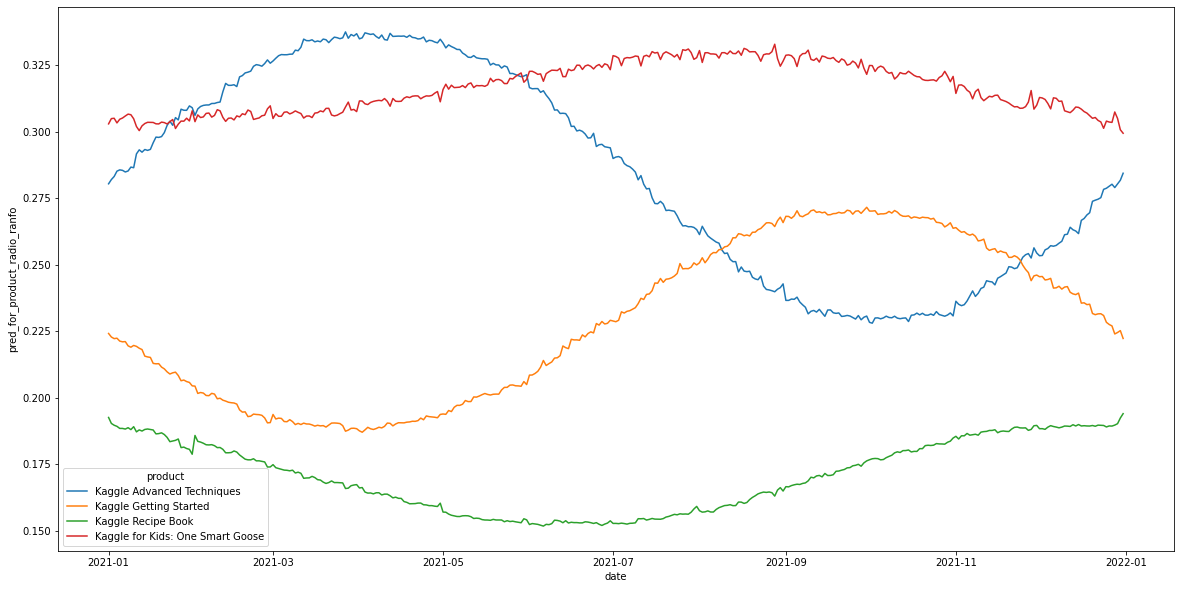

In [899]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = test_see_product_radio, x="date", y="pred_for_product_radio_ranfo", hue="product");

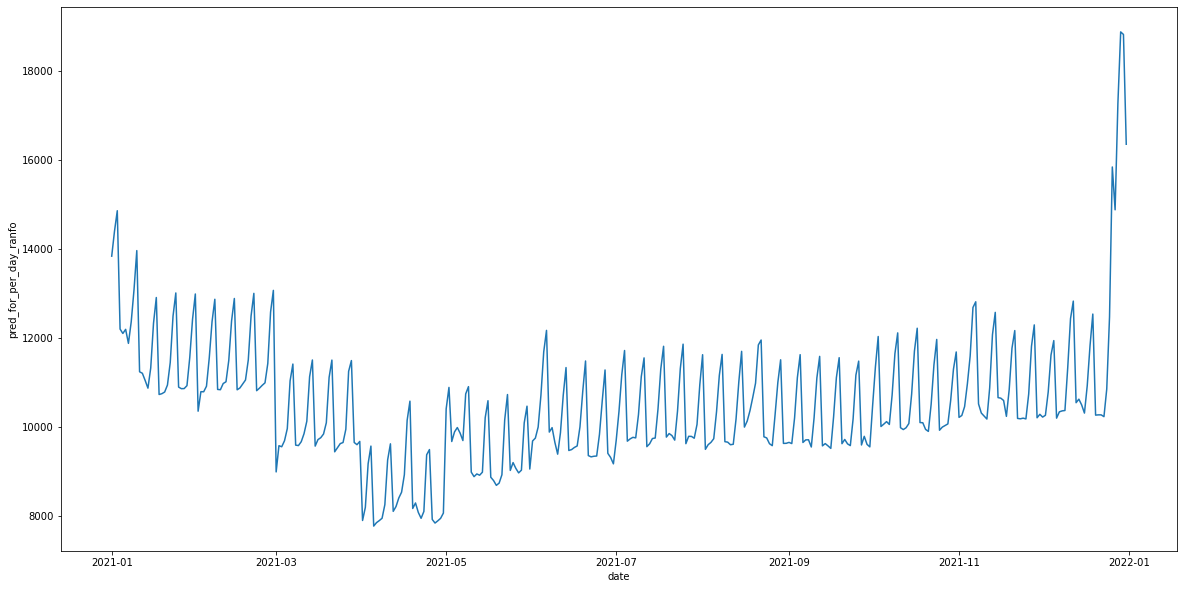

In [900]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = test_see_per_day, x= 'date', y="pred_for_per_day_ranfo");

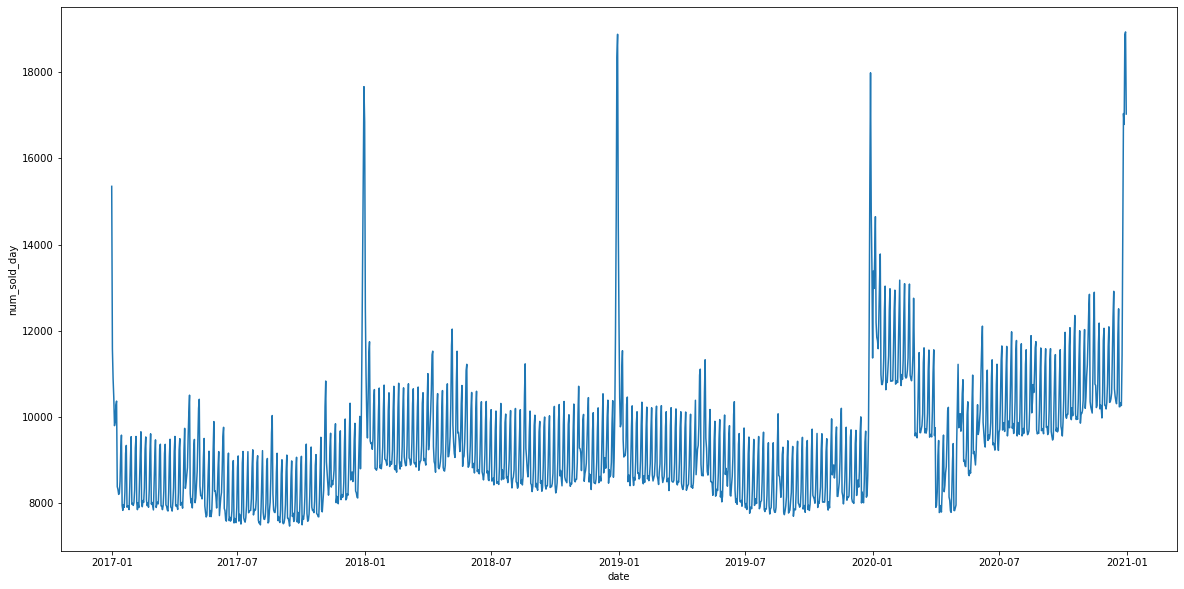

In [901]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_sold, x= 'date', y="num_sold_day");

In [902]:
test_see_per_day

date  pred_for_per_day_ranfo
0   2021-01-01            13840.426758
1   2021-01-02            14401.348633
2   2021-01-03            14862.386719
3   2021-01-04            12201.971680
4   2021-01-05            12103.435547
..         ...                     ...
360 2021-12-27            14882.731445
361 2021-12-28            17272.539062
362 2021-12-29            18881.933594
363 2021-12-30            18824.244141
364 2021-12-31            16356.627930

[365 rows x 2 columns]

In [903]:
test_data = []
test_data = test_see_product_radio.merge(test_see_per_day, on = ['date'], how = 'left')
test_data = test_data.rename({"pred_for_per_day_ranfo" : 'num_sold_total'}, axis = 1)
test_data
for i in range (0, len(test_data)):
    test_data['num_sold_total'][i] = test_data['num_sold_total'][i] * test_data['pred_for_product_radio_ranfo'][i]
#     new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
test_data

C:\Users\cym80\AppData\Local\Temp\ipykernel_6132\3039986401.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['num_sold_total'][i] = test_data['num_sold_total'][i] * test_data['pred_for_product_radio_ranfo'][i]


date                           product  \
0    2021-01-01        Kaggle Advanced Techniques   
1    2021-01-01            Kaggle Getting Started   
2    2021-01-01                Kaggle Recipe Book   
3    2021-01-01  Kaggle for Kids: One Smart Goose   
4    2021-01-02        Kaggle Advanced Techniques   
...         ...                               ...   
1455 2021-12-30  Kaggle for Kids: One Smart Goose   
1456 2021-12-31        Kaggle Advanced Techniques   
1457 2021-12-31            Kaggle Getting Started   
1458 2021-12-31                Kaggle Recipe Book   
1459 2021-12-31  Kaggle for Kids: One Smart Goose   

      pred_for_product_radio_ranfo  num_sold_total  
0                         0.280362     3880.326660  
1                         0.224157     3102.428711  
2                         0.192613     2665.846924  
3                         0.302868     4191.824707  
4                         0.281955     4060.536133  
...                            ...             ...  
1455                      0.300662     5659.740234  
1456                      0.284332     4650.715332  
1457                      0.222277     3635.701172  
1458                      0.194044     3173.907471  
1459                      0.299347     4896.304688  

[1460 rows x 4 columns]

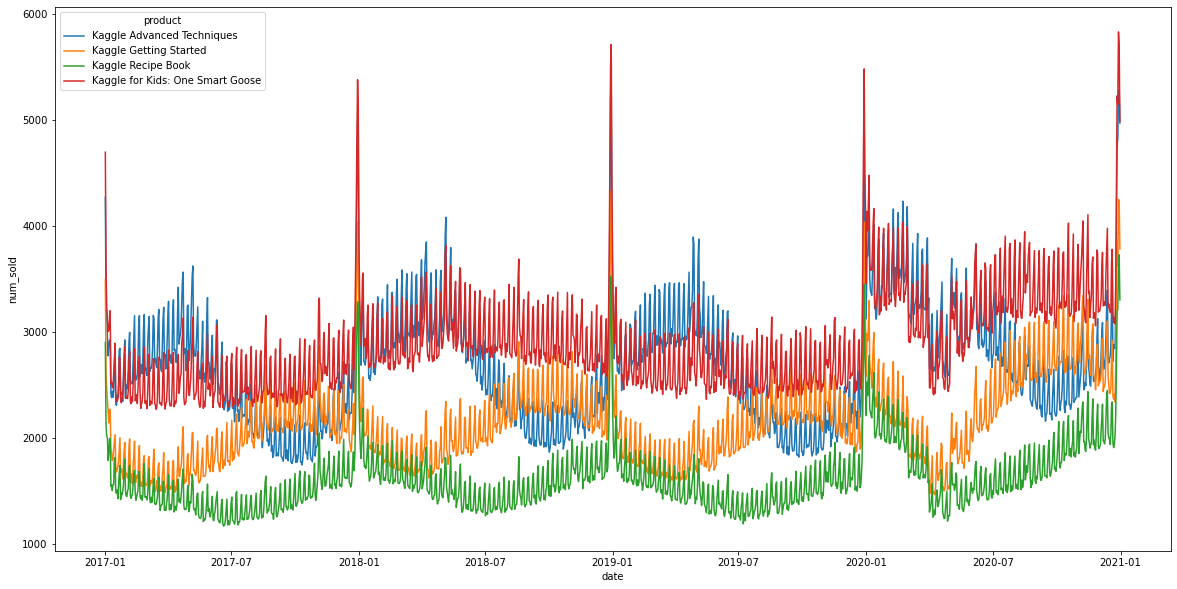

In [904]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

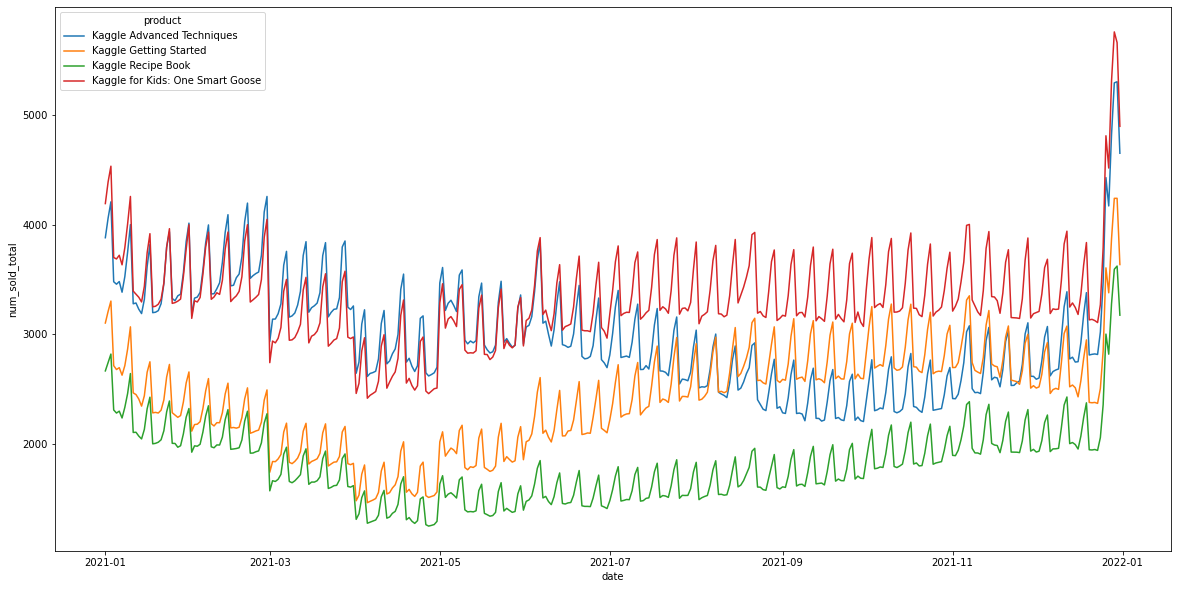

In [905]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = test_data, x= 'date', y="num_sold_total", hue = 'product');

In [906]:
test_data = test.merge(test_data, on = ['date', 'product'], how = 'left')
test_data

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  pred_for_product_radio_ranfo  \
0            Kaggle Advanced Techniques                      0.280362   
1                Kaggle Getting Started                      0.224157   
2                    Kaggle Recipe Book                      0.192613   
3      Kaggle for Kids: One Smart Goose                      0.302868   
4            Kaggle Advanced Techniques                      0.280362   
...                                 ...                           ...   
17515  Kaggle for Kids: One Smart Goose                      0.299347   
17516        Kaggle Advanced Techniques                      0.284332   
17517            Kaggle Getting Started                      0.222277   
17518                Kaggle Recipe Book                      0.194044   
17519  Kaggle for Kids: One Smart Goose                      0.299347   

       num_sold_total  
0         3880.326660  
1         3102.428711  
2         2665.846924  
3         4191.824707  
4         3880.326660  
...               ...  
17515     4896.304688  
17516     4650.715332  
17517     3635.701172  
17518     3173.907471  
17519     4896.304688  

[17520 rows x 7 columns]

In [907]:
country_weights_after = pd.DataFrame(country_weights_after_2020.copy())
country_weights_after

country_weights
country                 
Belgium         0.166528
France          0.166696
Germany         0.166257
Italy           0.167007
Poland          0.167162
Spain           0.166349

In [908]:
test_data = test_data.merge(country_weights_after, on = ['country'], how = 'left')
test_data

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  pred_for_product_radio_ranfo  \
0            Kaggle Advanced Techniques                      0.280362   
1                Kaggle Getting Started                      0.224157   
2                    Kaggle Recipe Book                      0.192613   
3      Kaggle for Kids: One Smart Goose                      0.302868   
4            Kaggle Advanced Techniques                      0.280362   
...                                 ...                           ...   
17515  Kaggle for Kids: One Smart Goose                      0.299347   
17516        Kaggle Advanced Techniques                      0.284332   
17517            Kaggle Getting Started                      0.222277   
17518                Kaggle Recipe Book                      0.194044   
17519  Kaggle for Kids: One Smart Goose                      0.299347   

       num_sold_total  country_weights  
0         3880.326660         0.166528  
1         3102.428711         0.166528  
2         2665.846924         0.166528  
3         4191.824707         0.166528  
4         3880.326660         0.166528  
...               ...              ...  
17515     4896.304688         0.166349  
17516     4650.715332         0.166349  
17517     3635.701172         0.166349  
17518     3173.907471         0.166349  
17519     4896.304688         0.166349  

[17520 rows x 8 columns]

In [909]:
store_weights = pd.DataFrame(store_weights)
store_weights

store_weights
store                    
KaggleMart       0.742515
KaggleRama       0.257485

In [910]:
test_data = test_data.merge(store_weights, on = ['store'], how = 'left')
test_data

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  pred_for_product_radio_ranfo  \
0            Kaggle Advanced Techniques                      0.280362   
1                Kaggle Getting Started                      0.224157   
2                    Kaggle Recipe Book                      0.192613   
3      Kaggle for Kids: One Smart Goose                      0.302868   
4            Kaggle Advanced Techniques                      0.280362   
...                                 ...                           ...   
17515  Kaggle for Kids: One Smart Goose                      0.299347   
17516        Kaggle Advanced Techniques                      0.284332   
17517            Kaggle Getting Started                      0.222277   
17518                Kaggle Recipe Book                      0.194044   
17519  Kaggle for Kids: One Smart Goose                      0.299347   

       num_sold_total  country_weights  store_weights  
0         3880.326660         0.166528       0.742515  
1         3102.428711         0.166528       0.742515  
2         2665.846924         0.166528       0.742515  
3         4191.824707         0.166528       0.742515  
4         3880.326660         0.166528       0.257485  
...               ...              ...            ...  
17515     4896.304688         0.166349       0.742515  
17516     4650.715332         0.166349       0.257485  
17517     3635.701172         0.166349       0.257485  
17518     3173.907471         0.166349       0.257485  
17519     4896.304688         0.166349       0.257485  

[17520 rows x 9 columns]

In [911]:
for i in range(0, len(test_data)):
    test_data['num_sold_total'][i] = test_data['num_sold_total'][i] * test_data['country_weights'][i] * test_data['store_weights'][i]
    
test_data

C:\Users\cym80\AppData\Local\Temp\ipykernel_6132\2466806511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['num_sold_total'][i] = test_data['num_sold_total'][i] * test_data['country_weights'][i] * test_data['store_weights'][i]


row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  pred_for_product_radio_ranfo  \
0            Kaggle Advanced Techniques                      0.280362   
1                Kaggle Getting Started                      0.224157   
2                    Kaggle Recipe Book                      0.192613   
3      Kaggle for Kids: One Smart Goose                      0.302868   
4            Kaggle Advanced Techniques                      0.280362   
...                                 ...                           ...   
17515  Kaggle for Kids: One Smart Goose                      0.299347   
17516        Kaggle Advanced Techniques                      0.284332   
17517            Kaggle Getting Started                      0.222277   
17518                Kaggle Recipe Book                      0.194044   
17519  Kaggle for Kids: One Smart Goose                      0.299347   

       num_sold_total  country_weights  store_weights  
0          479.800812         0.166528       0.742515  
1          383.614044         0.166528       0.742515  
2          329.630890         0.166528       0.742515  
3          518.317444         0.166528       0.742515  
4          166.382660         0.166528       0.257485  
...               ...              ...            ...  
17515      604.774414         0.166349       0.742515  
17516      199.201141         0.166349       0.257485  
17517      155.725677         0.166349       0.257485  
17518      135.945969         0.166349       0.257485  
17519      209.720306         0.166349       0.257485  

[17520 rows x 9 columns]

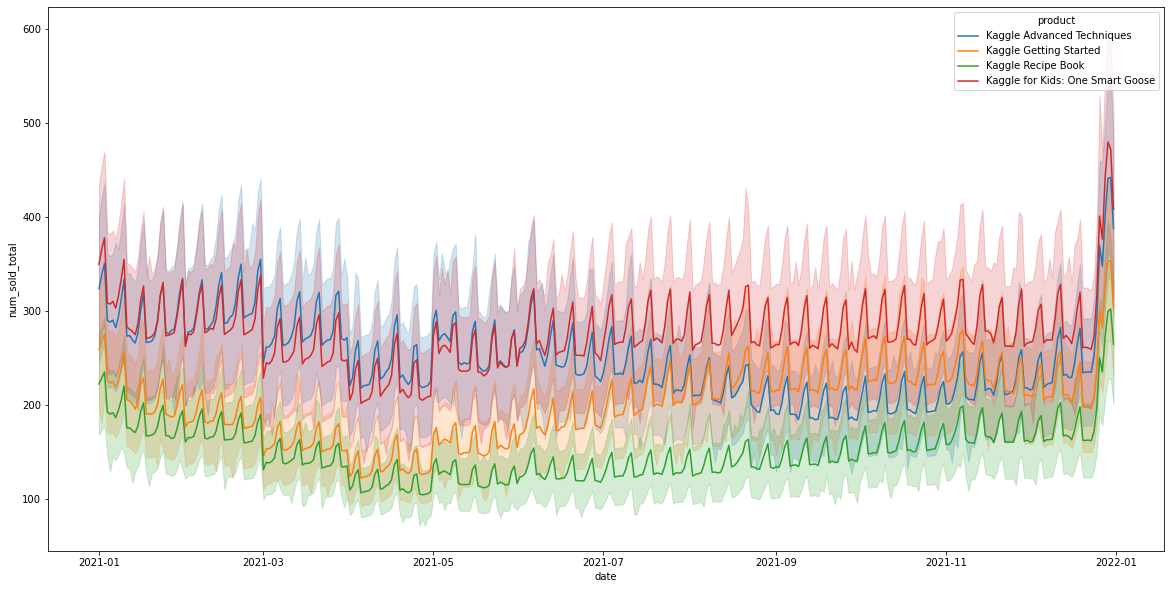

In [912]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = test_data, x= 'date', y="num_sold_total", hue = 'product');

In [913]:
def plot_all_see(df):
    f, axes = plt.subplots(2, 2, figsize = (20, 15), sharex = True, sharey = True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data = plot_df, x = 'date', y = 'num_sold_total', hue = 'country', style = 'store', ax = axes[n // 2, n% 2])
        axes[n // 2, n % 2].set_title("Product: "+str(prod))

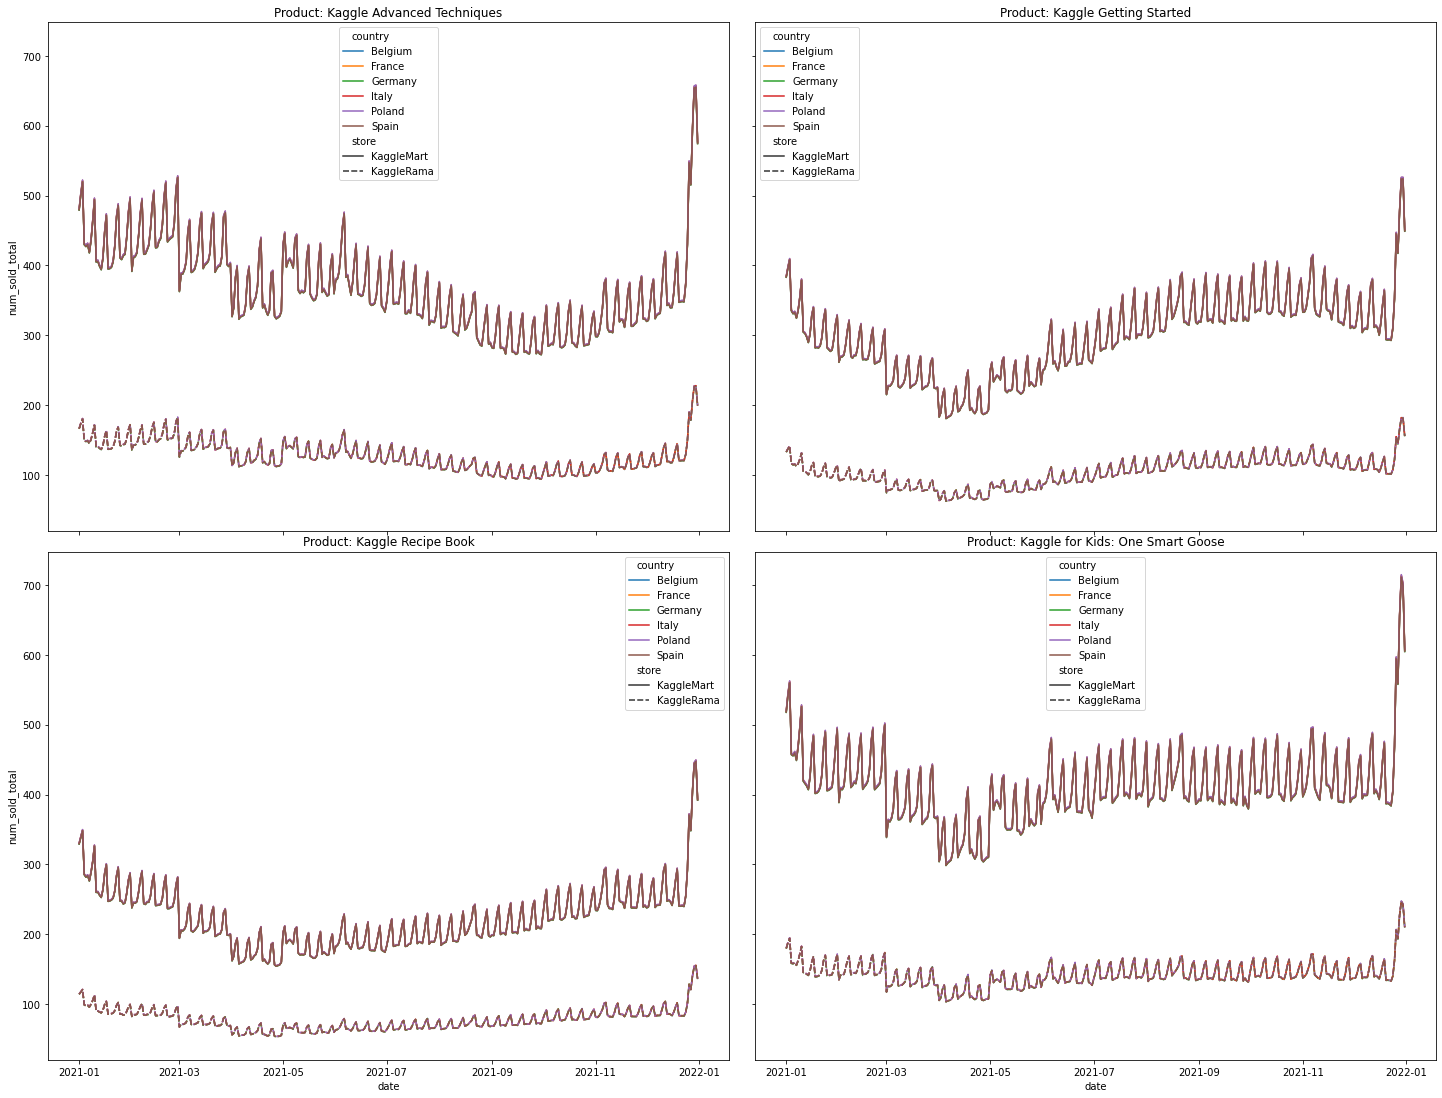

In [914]:
plot_all_see(test_data)

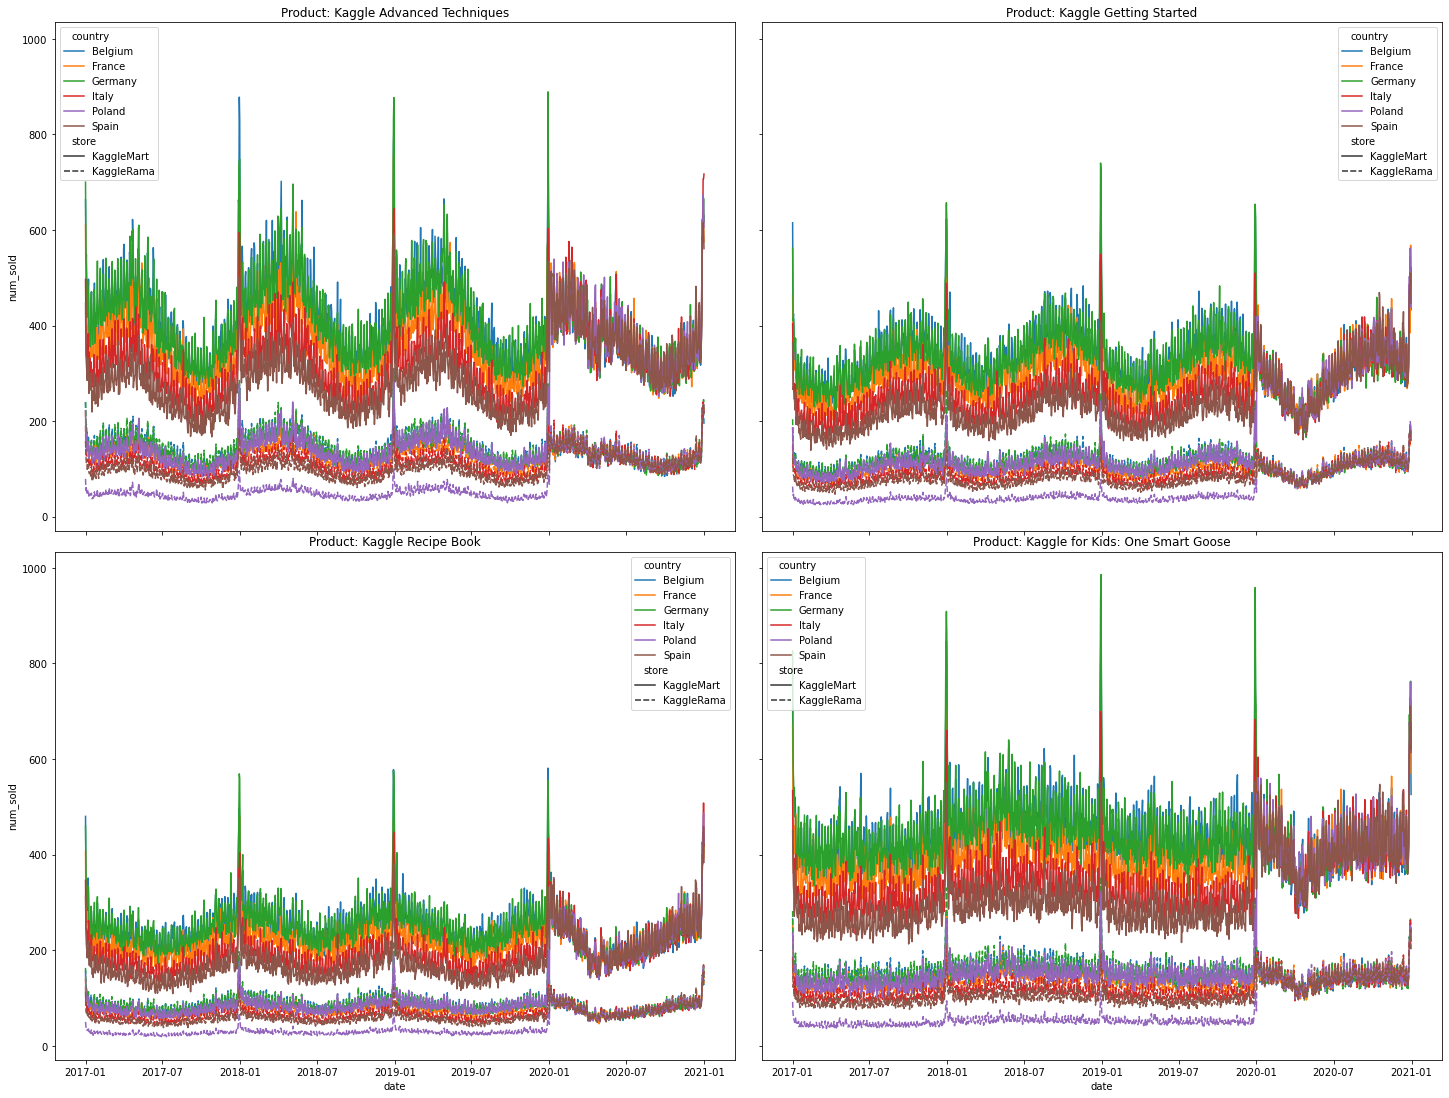

In [915]:
plot_all(train)

In [916]:
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': test_data['num_sold_total']})
output.to_csv('XGB.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [91]:
store_weights
store_weights_mul = store_weights['KaggleMart'] / store_weights
store_weights_mul

store
KaggleMart    1.000000
KaggleRama    2.883719
Name: store_weights, dtype: float64

In [92]:
country_weights
country_weights_mul = country_weights['Belgium'] / country_weights
country_weights_mul

country
Belgium    1.000000
France     1.144078
Germany    0.997013
Italy      1.373611
Poland     3.068492
Spain      1.570602
Name: country_weights, dtype: float64

In [93]:
product_weights
product_weights_mul = product_weights['Kaggle Advanced Techniques'] / product_weights
product_weights_mul

product
Kaggle Advanced Techniques          1.000000
Kaggle Getting Started              1.247699
Kaggle Recipe Book                  1.665623
Kaggle for Kids: One Smart Goose    0.926363
Name: product_weights, dtype: float64

In [117]:
test = pd.read_csv(path + '/test.csv', parse_dates=["date"]).copy()
train = pd.read_csv(path + '/train.csv', parse_dates=["date"]).copy()

from sklearn.preprocessing import LabelEncoder
def change_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    data = data.merge(store_weights, on = ['store'], how = 'left')
    data = data.merge(product_weights, on = ['product'], how = 'left')
#     data = data.merge(country_weights, on = ['country'], how = 'left')
    
    return data

train = change_data(train)
test = change_data(test)
train

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  year  month  day  \
0            Kaggle Advanced Techniques       663  2017      1    1   
1                Kaggle Getting Started       615  2017      1    1   
2                    Kaggle Recipe Book       480  2017      1    1   
3      Kaggle for Kids: One Smart Goose       710  2017      1    1   
4            Kaggle Advanced Techniques       240  2017      1    1   
...                                 ...       ...   ...    ...  ...   
70123  Kaggle for Kids: One Smart Goose       614  2020     12   31   
70124        Kaggle Advanced Techniques       215  2020     12   31   
70125            Kaggle Getting Started       158  2020     12   31   
70126                Kaggle Recipe Book       135  2020     12   31   
70127  Kaggle for Kids: One Smart Goose       202  2020     12   31   

       dayofweek  quarter  store_weights  product_weights  country_weights  
0              6        1       0.742515         0.287246         0.218930  
1              6        1       0.742515         0.230220         0.218930  
2              6        1       0.742515         0.172455         0.218930  
3              6        1       0.742515         0.310079         0.218930  
4              6        1       0.257485         0.287246         0.218930  
...          ...      ...            ...              ...              ...  
70123          3        4       0.742515         0.310079         0.139393  
70124          3        4       0.257485         0.287246         0.139393  
70125          3        4       0.257485         0.230220         0.139393  
70126          3        4       0.257485         0.172455         0.139393  
70127          3        4       0.257485         0.310079         0.139393  

[70128 rows x 14 columns]

In [118]:
test

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  year  month  day  dayofweek  quarter  \
0            Kaggle Advanced Techniques  2021      1    1          4        1   
1                Kaggle Getting Started  2021      1    1          4        1   
2                    Kaggle Recipe Book  2021      1    1          4        1   
3      Kaggle for Kids: One Smart Goose  2021      1    1          4        1   
4            Kaggle Advanced Techniques  2021      1    1          4        1   
...                                 ...   ...    ...  ...        ...      ...   
17515  Kaggle for Kids: One Smart Goose  2021     12   31          4        4   
17516        Kaggle Advanced Techniques  2021     12   31          4        4   
17517            Kaggle Getting Started  2021     12   31          4        4   
17518                Kaggle Recipe Book  2021     12   31          4        4   
17519  Kaggle for Kids: One Smart Goose  2021     12   31          4        4   

       store_weights  product_weights  country_weights  
0           0.742515         0.287246         0.218930  
1           0.742515         0.230220         0.218930  
2           0.742515         0.172455         0.218930  
3           0.742515         0.310079         0.218930  
4           0.257485         0.287246         0.218930  
...              ...              ...              ...  
17515       0.742515         0.310079         0.139393  
17516       0.257485         0.287246         0.139393  
17517       0.257485         0.230220         0.139393  
17518       0.257485         0.172455         0.139393  
17519       0.257485         0.310079         0.139393  

[17520 rows x 13 columns]

In [119]:
# for i in range(0, len(train)):
#     if train['year'][i] > 2019:
#         if train['country'][i] == 'Belgium':
#             train['country_weights'][i] = country_weights_after_2020.loc["Belgium"]
#         elif train['country'][i] == 'France':
#             train['country_weights'][i] = country_weights_after_2020.loc["France"]
#         elif train['country'][i] == 'Germany':
#             train['country_weights'][i] = country_weights_after_2020.loc["Germany"]
#         elif train['country'][i] == 'Italy':
#             train['country_weights'][i] = country_weights_after_2020.loc["Italy"]
#         elif train['country'][i] == 'Poland':
#             train['country_weights'][i] = country_weights_after_2020.loc["Poland"]
#         elif train['country'][i] == 'Spain':
#             train['country_weights'][i] = country_weights_after_2020.loc["Spain"]

C:\Users\cym80\AppData\Local\Temp\ipykernel_8828\501906029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['country_weights'][i] = country_weights_after_2020.loc["Belgium"]
C:\Users\cym80\AppData\Local\Temp\ipykernel_8828\501906029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['country_weights'][i] = country_weights_after_2020.loc["France"]
C:\Users\cym80\AppData\Local\Temp\ipykernel_8828\501906029.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [120]:
# for i in range(0, len(test)):
#     if test['year'][i] > 2019:
#         if test['country'][i] == 'Belgium':
#             test['country_weights'][i] = country_weights_after_2020.loc["Belgium"]
#         elif test['country'][i] == 'France':
#             test['country_weights'][i] = country_weights_after_2020.loc["France"]
#         elif test['country'][i] == 'Germany':
#             test['country_weights'][i] = country_weights_after_2020.loc["Germany"]
#         elif test['country'][i] == 'Italy':
#             test['country_weights'][i] = country_weights_after_2020.loc["Italy"]
#         elif test['country'][i] == 'Poland':
#             test['country_weights'][i] = country_weights_after_2020.loc["Poland"]
#         elif test['country'][i] == 'Spain':
#             test['country_weights'][i] = country_weights_after_2020.loc["Spain"]

C:\Users\cym80\AppData\Local\Temp\ipykernel_8828\2297716184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['country_weights'][i] = country_weights_after_2020.loc["Belgium"]
C:\Users\cym80\AppData\Local\Temp\ipykernel_8828\2297716184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['country_weights'][i] = country_weights_after_2020.loc["France"]
C:\Users\cym80\AppData\Local\Temp\ipykernel_8828\2297716184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [121]:
test

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  year  month  day  dayofweek  quarter  \
0            Kaggle Advanced Techniques  2021      1    1          4        1   
1                Kaggle Getting Started  2021      1    1          4        1   
2                    Kaggle Recipe Book  2021      1    1          4        1   
3      Kaggle for Kids: One Smart Goose  2021      1    1          4        1   
4            Kaggle Advanced Techniques  2021      1    1          4        1   
...                                 ...   ...    ...  ...        ...      ...   
17515  Kaggle for Kids: One Smart Goose  2021     12   31          4        4   
17516        Kaggle Advanced Techniques  2021     12   31          4        4   
17517            Kaggle Getting Started  2021     12   31          4        4   
17518                Kaggle Recipe Book  2021     12   31          4        4   
17519  Kaggle for Kids: One Smart Goose  2021     12   31          4        4   

       store_weights  product_weights  country_weights  
0           0.742515         0.287246         0.166528  
1           0.742515         0.230220         0.166528  
2           0.742515         0.172455         0.166528  
3           0.742515         0.310079         0.166528  
4           0.257485         0.287246         0.166528  
...              ...              ...              ...  
17515       0.742515         0.310079         0.166349  
17516       0.257485         0.287246         0.166349  
17517       0.257485         0.230220         0.166349  
17518       0.257485         0.172455         0.166349  
17519       0.257485         0.310079         0.166349  

[17520 rows x 13 columns]

In [122]:
from catboost import CatBoostRegressor
X_train = train.drop(['num_sold'], axis = 1)
y_train = train['num_sold'].copy()
categorical_features_names = ['country', 'store', 'product']

model = CatBoostRegressor(n_estimators=500, random_state = 42, cat_features = categorical_features_names)
model.fit(X_train, y_train)

Learning rate set to 0.140789
0:	learn: 110.9267772	total: 39ms	remaining: 19.4s
1:	learn: 97.8605747	total: 71.3ms	remaining: 17.7s
2:	learn: 86.3010747	total: 97.2ms	remaining: 16.1s
3:	learn: 76.8952212	total: 130ms	remaining: 16.1s
4:	learn: 68.7777401	total: 162ms	remaining: 16s
5:	learn: 62.0236535	total: 193ms	remaining: 15.9s
6:	learn: 56.3630130	total: 226ms	remaining: 15.9s
7:	learn: 51.6462246	total: 259ms	remaining: 15.9s
8:	learn: 47.5773797	total: 289ms	remaining: 15.8s
9:	learn: 44.3889872	total: 323ms	remaining: 15.8s
10:	learn: 41.2137350	total: 355ms	remaining: 15.8s
11:	learn: 38.7958449	total: 387ms	remaining: 15.8s
12:	learn: 36.9505686	total: 421ms	remaining: 15.8s
13:	learn: 35.3158709	total: 453ms	remaining: 15.7s
14:	learn: 33.9893010	total: 504ms	remaining: 16.3s
15:	learn: 32.4225332	total: 548ms	remaining: 16.6s
16:	learn: 31.3525134	total: 578ms	remaining: 16.4s
17:	learn: 30.2548499	total: 609ms	remaining: 16.3s
18:	learn: 29.5540132	total: 641ms	remaining

158:	learn: 15.3730683	total: 5.44s	remaining: 11.7s
159:	learn: 15.3596943	total: 5.47s	remaining: 11.6s
160:	learn: 15.3415418	total: 5.5s	remaining: 11.6s
161:	learn: 15.3282804	total: 5.53s	remaining: 11.5s
162:	learn: 15.3113561	total: 5.56s	remaining: 11.5s
163:	learn: 15.2578217	total: 5.59s	remaining: 11.5s
164:	learn: 15.2367295	total: 5.63s	remaining: 11.4s
165:	learn: 15.2259752	total: 5.66s	remaining: 11.4s
166:	learn: 15.2157275	total: 5.7s	remaining: 11.4s
167:	learn: 15.2039061	total: 5.73s	remaining: 11.3s
168:	learn: 15.1902695	total: 5.76s	remaining: 11.3s
169:	learn: 15.1715762	total: 5.79s	remaining: 11.2s
170:	learn: 15.1579750	total: 5.82s	remaining: 11.2s
171:	learn: 15.1438499	total: 5.85s	remaining: 11.2s
172:	learn: 15.1387578	total: 5.88s	remaining: 11.1s
173:	learn: 15.1343261	total: 5.91s	remaining: 11.1s
174:	learn: 15.1260538	total: 5.94s	remaining: 11s
175:	learn: 15.1101201	total: 5.97s	remaining: 11s
176:	learn: 15.0936796	total: 6s	remaining: 11s
177:

315:	learn: 13.8781011	total: 10.6s	remaining: 6.14s
316:	learn: 13.8743138	total: 10.6s	remaining: 6.11s
317:	learn: 13.8670660	total: 10.6s	remaining: 6.08s
318:	learn: 13.8569150	total: 10.6s	remaining: 6.04s
319:	learn: 13.8522089	total: 10.7s	remaining: 6s
320:	learn: 13.8500446	total: 10.7s	remaining: 5.97s
321:	learn: 13.8496168	total: 10.7s	remaining: 5.93s
322:	learn: 13.8480769	total: 10.8s	remaining: 5.9s
323:	learn: 13.8452007	total: 10.8s	remaining: 5.86s
324:	learn: 13.8401178	total: 10.8s	remaining: 5.83s
325:	learn: 13.8319059	total: 10.9s	remaining: 5.79s
326:	learn: 13.8156196	total: 10.9s	remaining: 5.76s
327:	learn: 13.8141087	total: 10.9s	remaining: 5.72s
328:	learn: 13.8064634	total: 10.9s	remaining: 5.69s
329:	learn: 13.8016293	total: 11s	remaining: 5.65s
330:	learn: 13.7965929	total: 11s	remaining: 5.62s
331:	learn: 13.7936158	total: 11s	remaining: 5.58s
332:	learn: 13.7868017	total: 11.1s	remaining: 5.55s
333:	learn: 13.7785339	total: 11.1s	remaining: 5.51s
334

472:	learn: 13.2457620	total: 15.5s	remaining: 885ms
473:	learn: 13.2452936	total: 15.5s	remaining: 853ms
474:	learn: 13.2427008	total: 15.6s	remaining: 820ms
475:	learn: 13.2417004	total: 15.6s	remaining: 788ms
476:	learn: 13.2397254	total: 15.7s	remaining: 756ms
477:	learn: 13.2395007	total: 15.7s	remaining: 723ms
478:	learn: 13.2385791	total: 15.7s	remaining: 690ms
479:	learn: 13.2377390	total: 15.8s	remaining: 657ms
480:	learn: 13.2358989	total: 15.8s	remaining: 624ms
481:	learn: 13.2356501	total: 15.8s	remaining: 591ms
482:	learn: 13.2349917	total: 15.8s	remaining: 558ms
483:	learn: 13.2290988	total: 15.9s	remaining: 525ms
484:	learn: 13.2224254	total: 15.9s	remaining: 492ms
485:	learn: 13.2211787	total: 15.9s	remaining: 459ms
486:	learn: 13.2138408	total: 16s	remaining: 426ms
487:	learn: 13.2101545	total: 16s	remaining: 393ms
488:	learn: 13.2101124	total: 16s	remaining: 360ms
489:	learn: 13.2065515	total: 16.1s	remaining: 328ms
490:	learn: 13.2026497	total: 16.1s	remaining: 295ms

In [134]:
pred = model.predict(test)
pred

array([553.15630724, 419.17841981, 363.60622509, ..., 167.74085975,
       145.51730889, 227.61832471])

In [135]:
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': pred})
output.to_csv('cat.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [116]:
train = train.groupby(["date"])["num_sold"].sum().reset_index()

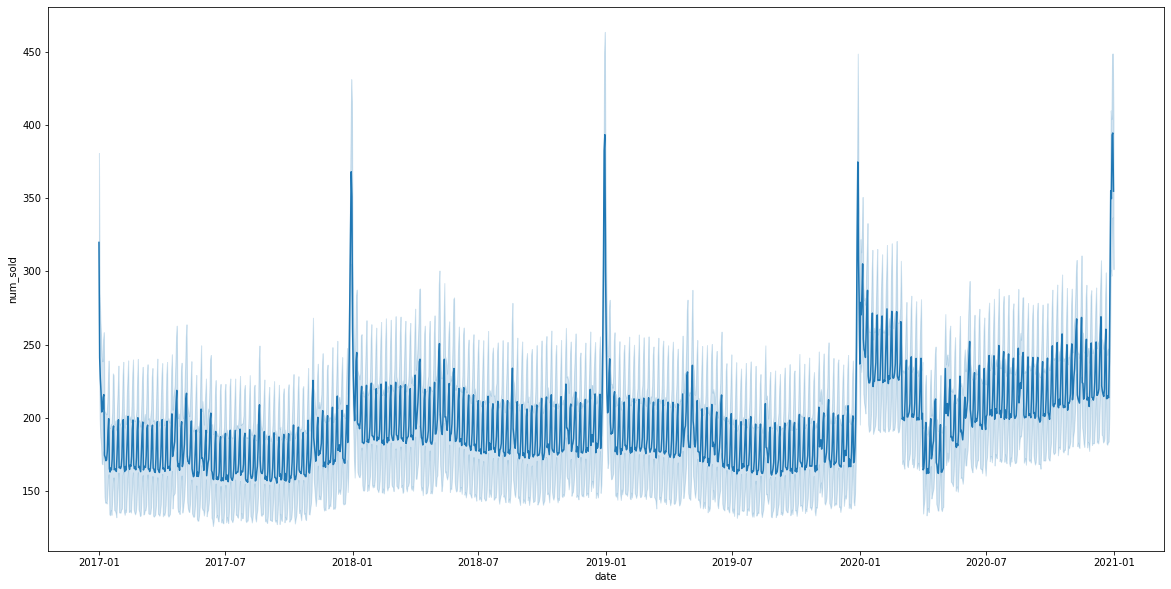

In [127]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_radio, x="date", y="num_sold");

In [118]:
weekly_df = train.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

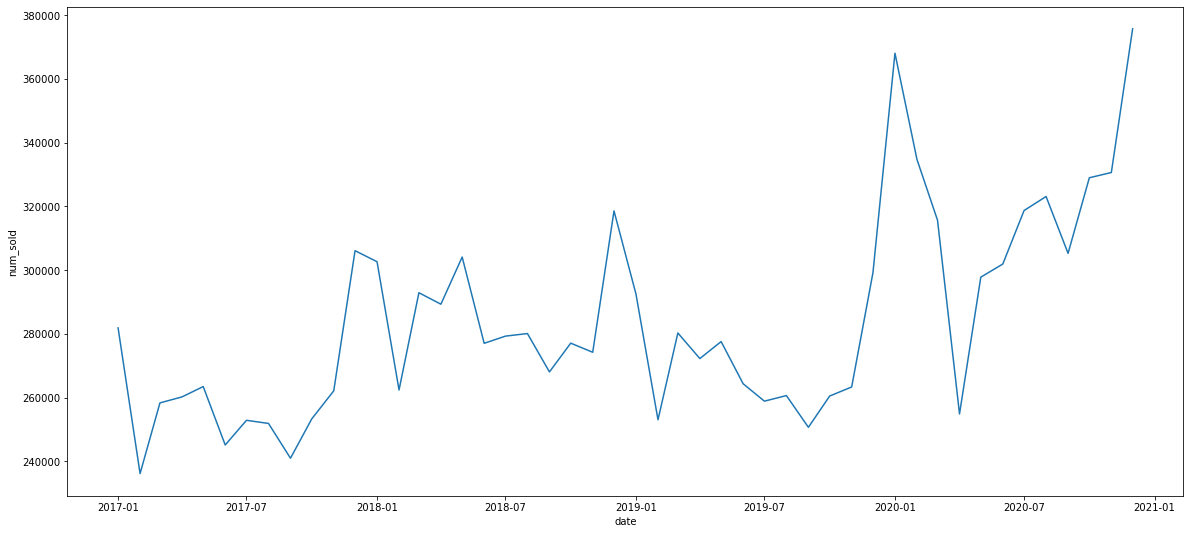

In [119]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=monthly_df, x="date", y="num_sold");

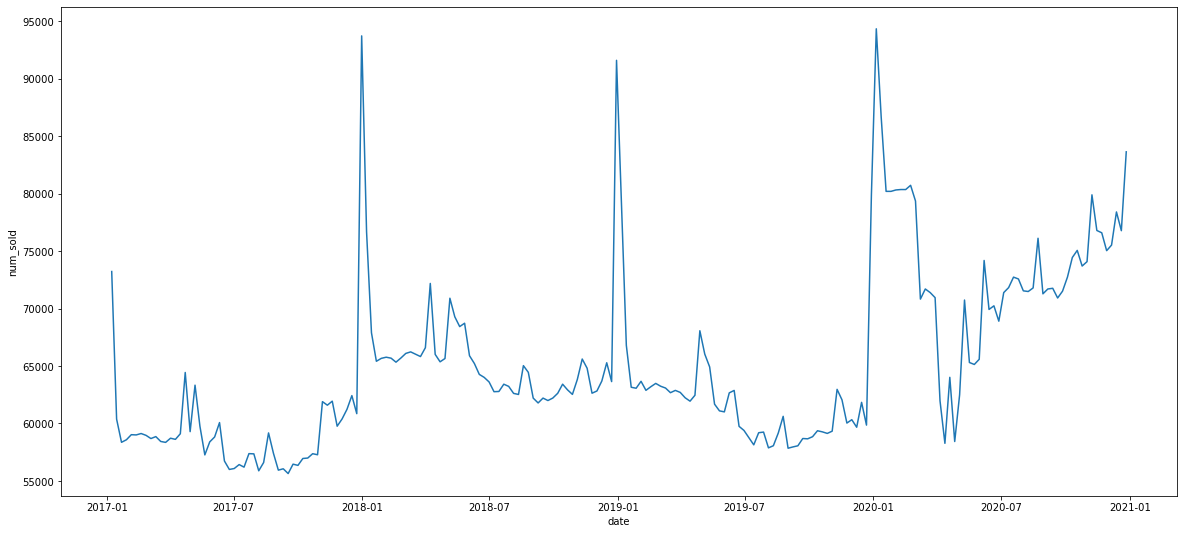

In [120]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=weekly_df[1:-1], x="date", y="num_sold");

In [151]:
train_radio["month"] = train_radio["date"].dt.month
train_radio["day_of_week"] = train_radio["date"].dt.dayofweek
train_radio["day_of_year"] = train_radio["date"].dt.dayofyear
#     윤년 빼는 이유 : dayofyear시 1년의 수가 365가 아닌 366으로 된다.
train_radio["day_of_year"] = train_radio.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)
# df["day_of_year"] = df.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)

def plot_seasonality(df, x_axis):
    #account for leap year
#     윤년 빼는 이유 : dayofyear시 1년의 수가 365가 아닌 366으로 된다.
        
    df_no_2020 = df.loc[df["date"] < "2020-01-01"]

    f,axes = plt.subplots(2,1,figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y="num_sold", ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y="num_sold", ax=axes[1]);
    axes[0].set_title("{} Seasonality - all years".format(x_axis))
    axes[1].set_title("{} Seasonality - not including 2020".format(x_axis))

In [152]:
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  \
0            Kaggle Advanced Techniques       663    0.736972      0.216258   
1                Kaggle Getting Started       615    0.736972      0.216258   
2                    Kaggle Recipe Book       480    0.736972      0.216258   
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258   
4            Kaggle Advanced Techniques       240    0.263028      0.216258   
...                                 ...       ...         ...           ...   
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474   
70124        Kaggle Advanced Techniques       215    0.261406      0.159474   
70125            Kaggle Getting Started       158    0.261406      0.159474   
70126                Kaggle Recipe Book       135    0.261406      0.159474   
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474   

       product_total_sell  product_radio  month  day_of_week  day_of_year  
0                    4267       0.277944      1            6            1  
1                    3492       0.227462      1            6            1  
2                    2900       0.188900      1            6            1  
3                    4693       0.305693      1            6            1  
4                    4267       0.277944      1            6            1  
...                   ...            ...    ...          ...          ...  
70123                4982       0.292525     12            3          365  
70124                4968       0.291703     12            3          365  
70125                3780       0.221948     12            3          365  
70126                3301       0.193823     12            3          365  
70127                4982       0.292525     12            3          365  

[70128 rows x 13 columns]

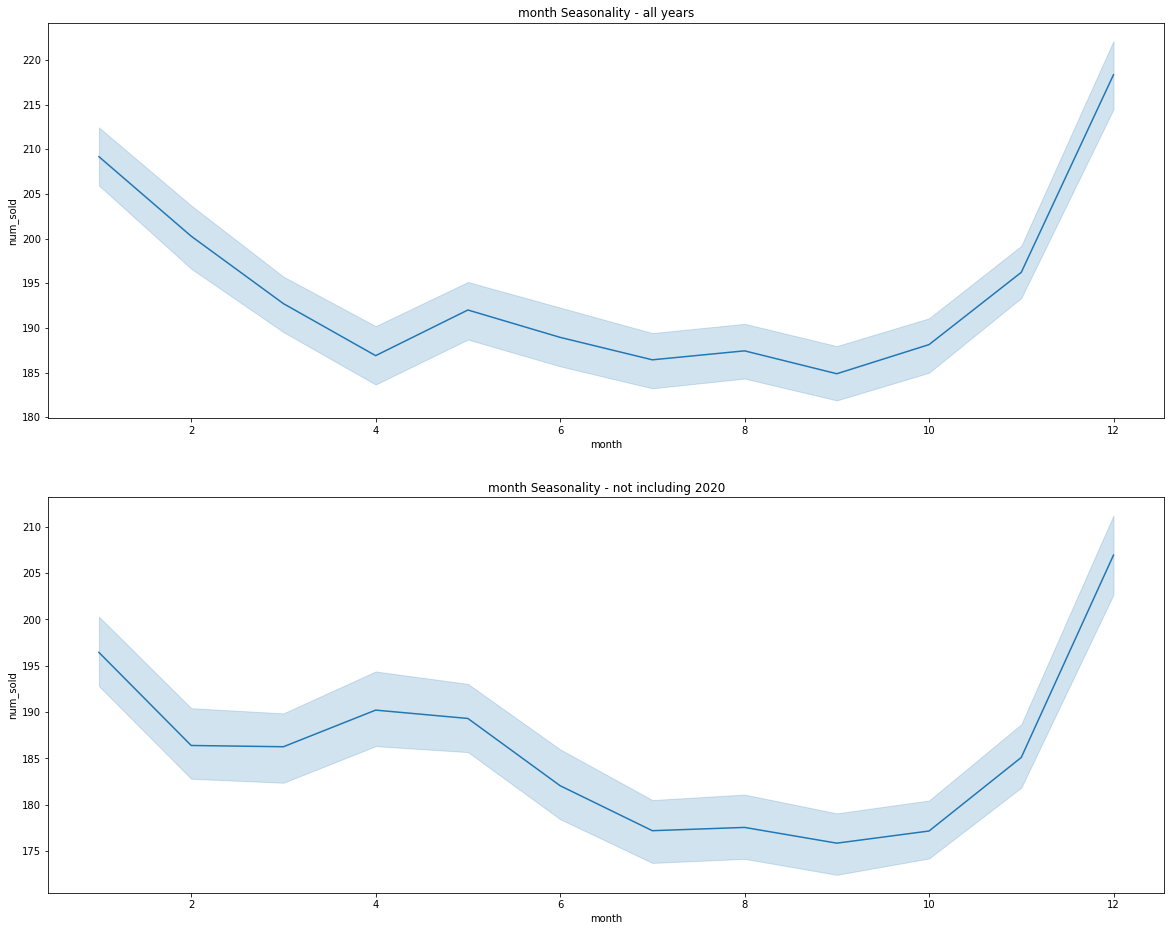

In [153]:
plot_seasonality(train_radio, "month")

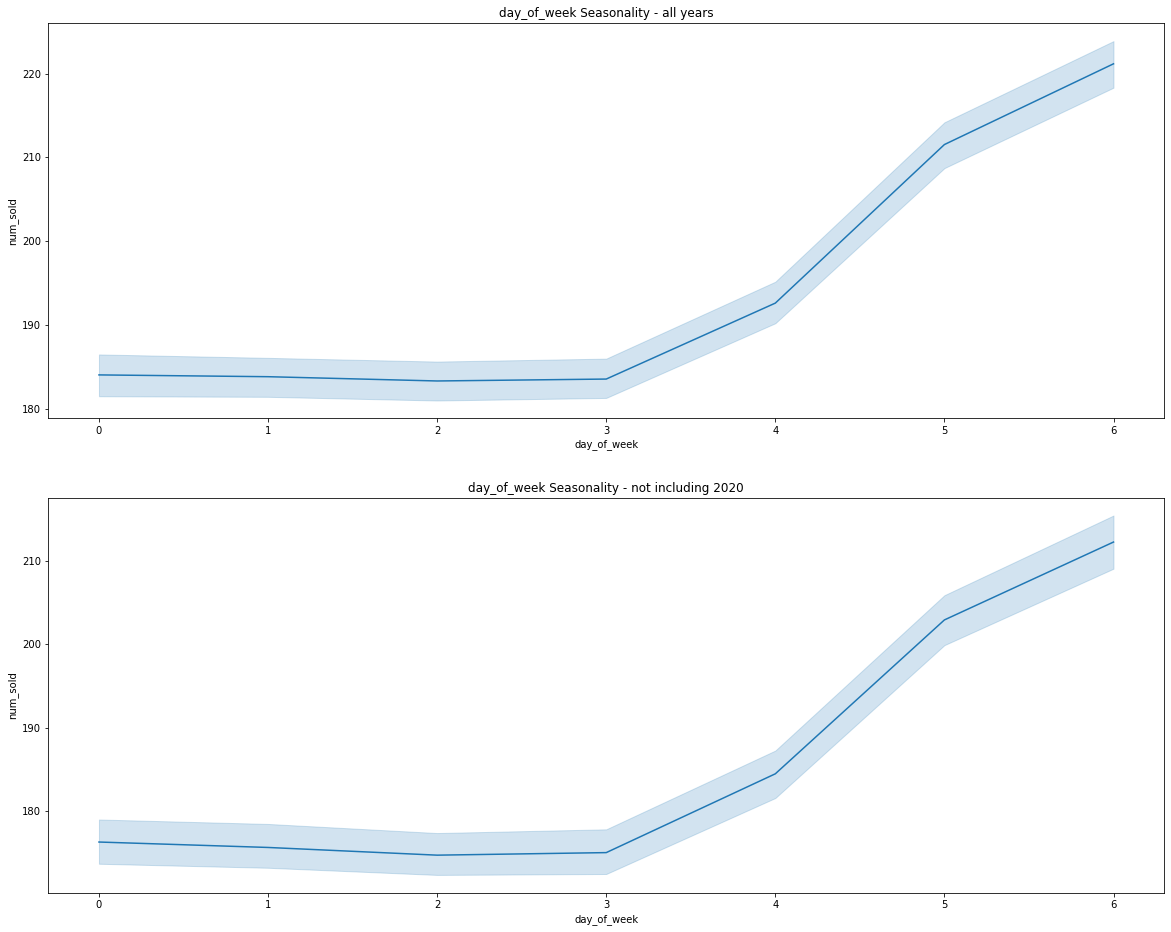

In [154]:
plot_seasonality(train_radio, "day_of_week")

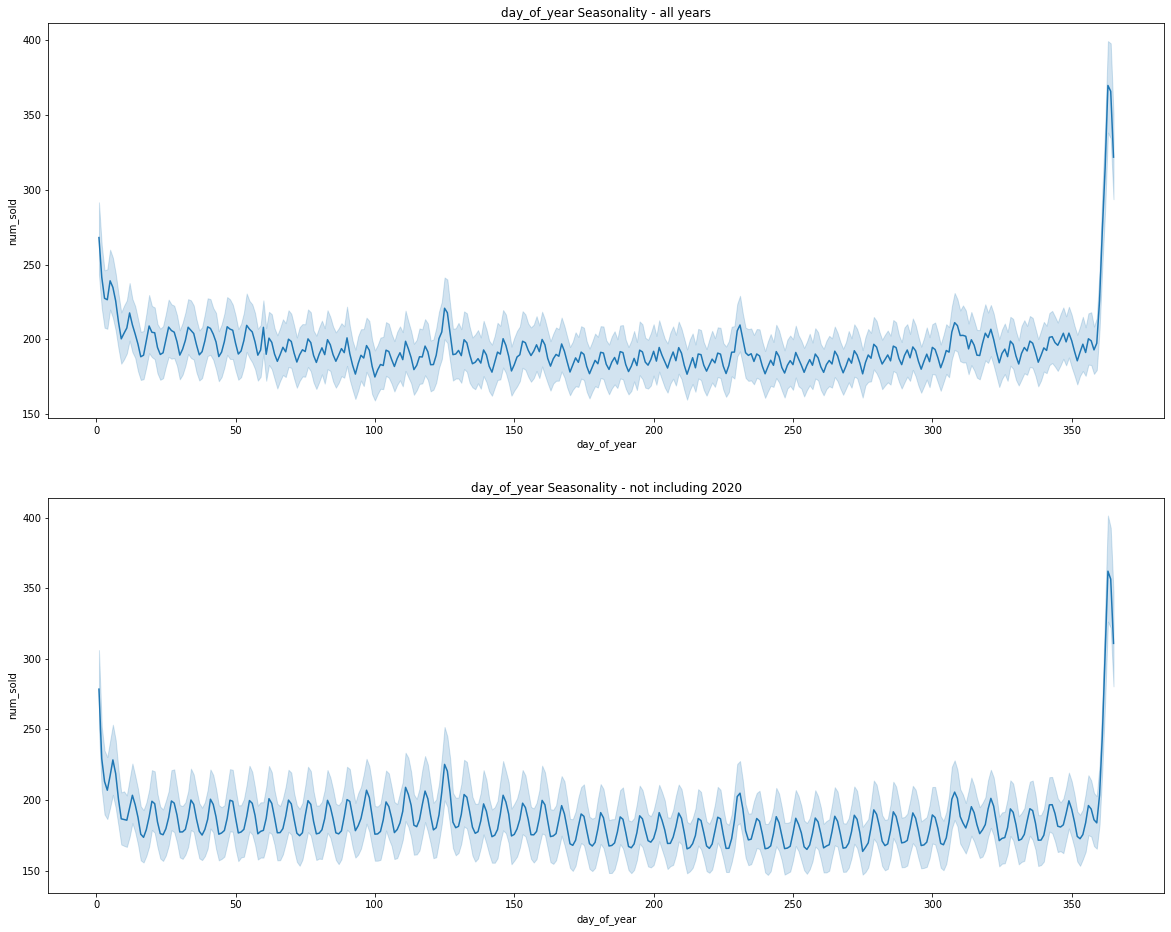

In [155]:
plot_seasonality(train_radio, "day_of_year")

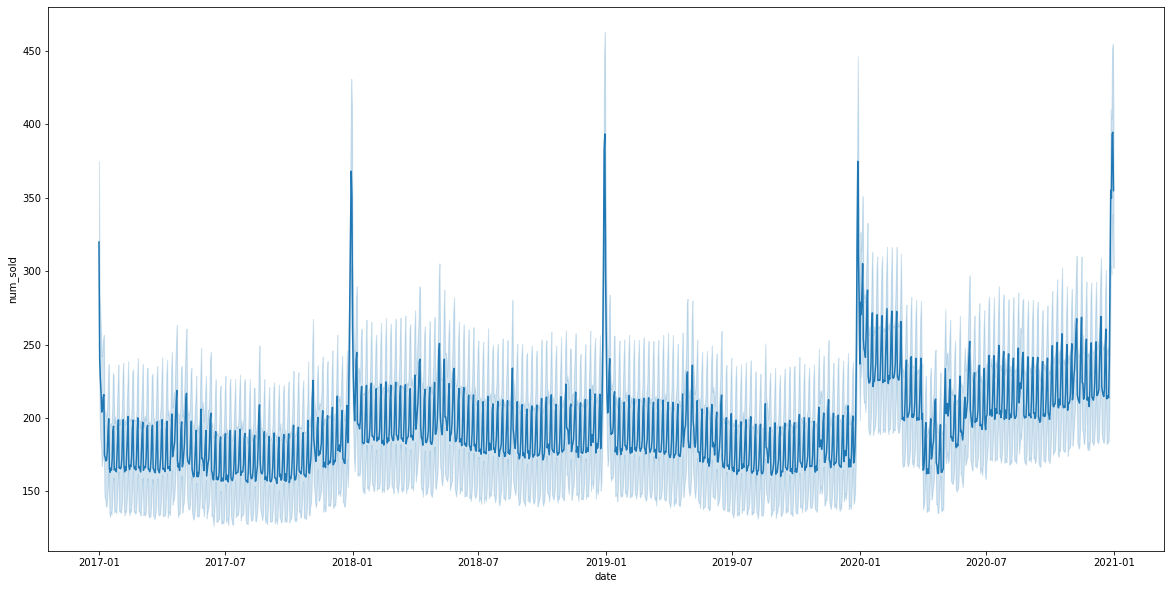

In [156]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_radio, x="date", y="num_sold");

In [157]:
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  \
0            Kaggle Advanced Techniques       663    0.736972      0.216258   
1                Kaggle Getting Started       615    0.736972      0.216258   
2                    Kaggle Recipe Book       480    0.736972      0.216258   
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258   
4            Kaggle Advanced Techniques       240    0.263028      0.216258   
...                                 ...       ...         ...           ...   
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474   
70124        Kaggle Advanced Techniques       215    0.261406      0.159474   
70125            Kaggle Getting Started       158    0.261406      0.159474   
70126                Kaggle Recipe Book       135    0.261406      0.159474   
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474   

       product_total_sell  product_radio  month  day_of_week  day_of_year  
0                    4267       0.277944      1            6            1  
1                    3492       0.227462      1            6            1  
2                    2900       0.188900      1            6            1  
3                    4693       0.305693      1            6            1  
4                    4267       0.277944      1            6            1  
...                   ...            ...    ...          ...          ...  
70123                4982       0.292525     12            3          365  
70124                4968       0.291703     12            3          365  
70125                3780       0.221948     12            3          365  
70126                3301       0.193823     12            3          365  
70127                4982       0.292525     12            3          365  

[70128 rows x 13 columns]

In [130]:
categorical_features_names = ['country', 'store', 'product']

In [132]:
train_radio[categorical_features_names].nunique()

country    6
store      2
product    4
dtype: int64

In [133]:
from catboost import CatBoostRegressor
X_train = train_radio.drop(['num_sold'], axis = 1)
y_train = train_radio['num_sold'].copy()

model = CatBoostRegressor(n_estimators=200, random_state = 42, cat_features = categorical_features_names)
model.fit(X_train, y_train)

Learning rate set to 0.296547
0:	learn: 92.3853635	total: 197ms	remaining: 39.2s
1:	learn: 67.8997205	total: 231ms	remaining: 22.9s
2:	learn: 50.4507012	total: 270ms	remaining: 17.7s
3:	learn: 38.0947058	total: 301ms	remaining: 14.8s
4:	learn: 29.1191981	total: 334ms	remaining: 13s
5:	learn: 23.1417191	total: 367ms	remaining: 11.9s
6:	learn: 19.0043942	total: 400ms	remaining: 11s
7:	learn: 16.1417821	total: 432ms	remaining: 10.4s
8:	learn: 14.4312789	total: 462ms	remaining: 9.81s
9:	learn: 13.3404220	total: 493ms	remaining: 9.37s
10:	learn: 12.6960034	total: 524ms	remaining: 9s
11:	learn: 12.2833766	total: 556ms	remaining: 8.71s
12:	learn: 12.0239553	total: 587ms	remaining: 8.44s
13:	learn: 11.8076691	total: 621ms	remaining: 8.24s
14:	learn: 11.6752811	total: 653ms	remaining: 8.05s
15:	learn: 11.4900914	total: 686ms	remaining: 7.89s
16:	learn: 11.3684378	total: 719ms	remaining: 7.74s
17:	learn: 11.2991571	total: 750ms	remaining: 7.58s
18:	learn: 11.2255085	total: 782ms	remaining: 7.45s

165:	learn: 9.5376901	total: 5.61s	remaining: 1.15s
166:	learn: 9.5367002	total: 5.64s	remaining: 1.11s
167:	learn: 9.5342948	total: 5.67s	remaining: 1.08s
168:	learn: 9.5305393	total: 5.71s	remaining: 1.05s
169:	learn: 9.5276300	total: 5.74s	remaining: 1.01s
170:	learn: 9.5257270	total: 5.77s	remaining: 979ms
171:	learn: 9.5243169	total: 5.8s	remaining: 945ms
172:	learn: 9.5231980	total: 5.83s	remaining: 911ms
173:	learn: 9.5226867	total: 5.86s	remaining: 876ms
174:	learn: 9.5226451	total: 5.89s	remaining: 841ms
175:	learn: 9.5196178	total: 5.92s	remaining: 808ms
176:	learn: 9.5166404	total: 5.96s	remaining: 774ms
177:	learn: 9.5148588	total: 5.99s	remaining: 740ms
178:	learn: 9.5116621	total: 6.06s	remaining: 711ms
179:	learn: 9.5084271	total: 6.11s	remaining: 679ms
180:	learn: 9.5052452	total: 6.18s	remaining: 648ms
181:	learn: 9.5051955	total: 6.21s	remaining: 614ms
182:	learn: 9.5043354	total: 6.29s	remaining: 585ms
183:	learn: 9.5042495	total: 6.32s	remaining: 550ms
184:	learn: 9

In [134]:
test_radio = test.copy()

In [136]:
def radio_rate(df):
    data = df.copy()
    data['store_rate'] = (data.groupby(["date",'store'])["num_sold"].sum() / data.groupby(["date"])["num_sold"].sum())
    data['country_rate'] = (data.groupby(["date",'country'])["num_sold"].sum() / data.groupby(["date"])["num_sold"].sum())
    data['product_total_sell'] = (data.groupby(["date",'store'])["num_sold"].sum() / data.groupby(["date"])["num_sold"].sum())
    return data

In [137]:
test_radio = radio_rate(test_radio)
test_radio

KeyError: 'Column not found: num_sold'

In [138]:
test

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  
0            Kaggle Advanced Techniques  
1                Kaggle Getting Started  
2                    Kaggle Recipe Book  
3      Kaggle for Kids: One Smart Goose  
4            Kaggle Advanced Techniques  
...                                 ...  
17515  Kaggle for Kids: One Smart Goose  
17516        Kaggle Advanced Techniques  
17517            Kaggle Getting Started  
17518                Kaggle Recipe Book  
17519  Kaggle for Kids: One Smart Goose  

[17520 rows x 5 columns]

In [83]:
# from sklearn.preprocessing import LabelEncoder
# def change_data(data):
#     data['date'] = pd.to_datetime(data['date'])
#     data['year'] = data['date'].dt.year
#     data['month'] = data['date'].dt.month
#     data['day'] = data['date'].dt.day
#     data['dayofweek'] = data['date'].dt.dayofweek
#     data['quarter'] = data['date'].dt.quarter
    
#     data['country'] = LabelEncoder().fit_transform(data['country'])
#     data['store'] = LabelEncoder().fit_transform(data['store'])
#     data['product'] = LabelEncoder().fit_transform(data['product'])
#     return data

# train_change = change_data(train)
# test_change = change_data(test)
# train_change

row_id       date  country  store  product  num_sold  year  month  day  \
0           0 2017-01-01        0      0        0       663  2017      1    1   
1           1 2017-01-01        0      0        1       615  2017      1    1   
2           2 2017-01-01        0      0        2       480  2017      1    1   
3           3 2017-01-01        0      0        3       710  2017      1    1   
4           4 2017-01-01        0      1        0       240  2017      1    1   
...       ...        ...      ...    ...      ...       ...   ...    ...  ...   
70123   70123 2020-12-31        5      0        3       614  2020     12   31   
70124   70124 2020-12-31        5      1        0       215  2020     12   31   
70125   70125 2020-12-31        5      1        1       158  2020     12   31   
70126   70126 2020-12-31        5      1        2       135  2020     12   31   
70127   70127 2020-12-31        5      1        3       202  2020     12   31   

       dayofweek  quarter  
0              6        1  
1              6        1  
2              6        1  
3              6        1  
4              6        1  
...          ...      ...  
70123          3        4  
70124          3        4  
70125          3        4  
70126          3        4  
70127          3        4  

[70128 rows x 11 columns]

In [84]:
test_change

row_id       date  country  store  product  year  month  day  \
0       70128 2021-01-01        0      0        0  2021      1    1   
1       70129 2021-01-01        0      0        1  2021      1    1   
2       70130 2021-01-01        0      0        2  2021      1    1   
3       70131 2021-01-01        0      0        3  2021      1    1   
4       70132 2021-01-01        0      1        0  2021      1    1   
...       ...        ...      ...    ...      ...   ...    ...  ...   
17515   87643 2021-12-31        5      0        3  2021     12   31   
17516   87644 2021-12-31        5      1        0  2021     12   31   
17517   87645 2021-12-31        5      1        1  2021     12   31   
17518   87646 2021-12-31        5      1        2  2021     12   31   
17519   87647 2021-12-31        5      1        3  2021     12   31   

       dayofweek  quarter  
0              4        1  
1              4        1  
2              4        1  
3              4        1  
4              4        1  
...          ...      ...  
17515          4        4  
17516          4        4  
17517          4        4  
17518          4        4  
17519          4        4  

[17520 rows x 10 columns]

In [85]:
train_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   row_id     70128 non-null  int64         
 1   date       70128 non-null  datetime64[ns]
 2   country    70128 non-null  int64         
 3   store      70128 non-null  int64         
 4   product    70128 non-null  int64         
 5   num_sold   70128 non-null  int64         
 6   year       70128 non-null  int64         
 7   month      70128 non-null  int64         
 8   day        70128 non-null  int64         
 9   dayofweek  70128 non-null  int64         
 10  quarter    70128 non-null  int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 5.9 MB


이 챌린지에서는 6개국에 있는 두 개의 경쟁 매장에서 4개 품목에 대한 1년 동안의 매출을 예측합니다. 이 데이터 세트는 완전히 허구이지만 실제 데이터에서 볼 수 있는 많은 효과(예: 주말 및 공휴일 효과, 계절성 등)가 포함되어 있습니다. 2021년 동안 책 판매를 예측하는 어려운 작업이 주어집니다.

In [86]:
X_train_drop = train_change.drop(['num_sold', 'date', 'row_id'], axis = 1)
X_train_drop_ = train_change.drop(['num_sold', 'row_id'], axis = 1)

y_train_drop = train_change['num_sold']
test_drop = test_change.drop(['date', 'row_id'], axis = 1)

In [87]:
X_train_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2017      1    1          6        1
1            0      0        1  2017      1    1          6        1
2            0      0        2  2017      1    1          6        1
3            0      0        3  2017      1    1          6        1
4            0      1        0  2017      1    1          6        1
...        ...    ...      ...   ...    ...  ...        ...      ...
70123        5      0        3  2020     12   31          3        4
70124        5      1        0  2020     12   31          3        4
70125        5      1        1  2020     12   31          3        4
70126        5      1        2  2020     12   31          3        4
70127        5      1        3  2020     12   31          3        4

[70128 rows x 8 columns]

In [88]:
test_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2021      1    1          4        1
1            0      0        1  2021      1    1          4        1
2            0      0        2  2021      1    1          4        1
3            0      0        3  2021      1    1          4        1
4            0      1        0  2021      1    1          4        1
...        ...    ...      ...   ...    ...  ...        ...      ...
17515        5      0        3  2021     12   31          4        4
17516        5      1        0  2021     12   31          4        4
17517        5      1        1  2021     12   31          4        4
17518        5      1        2  2021     12   31          4        4
17519        5      1        3  2021     12   31          4        4

[17520 rows x 8 columns]

In [89]:
X_train_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2017      1    1          6        1
1            0      0        1  2017      1    1          6        1
2            0      0        2  2017      1    1          6        1
3            0      0        3  2017      1    1          6        1
4            0      1        0  2017      1    1          6        1
...        ...    ...      ...   ...    ...  ...        ...      ...
70123        5      0        3  2020     12   31          3        4
70124        5      1        0  2020     12   31          3        4
70125        5      1        1  2020     12   31          3        4
70126        5      1        2  2020     12   31          3        4
70127        5      1        3  2020     12   31          3        4

[70128 rows x 8 columns]

In [90]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=train, x=X_train['store'], y=y_train, hue=X_train['date'])
# ax.legend().remove()
# plt.title('Product distribution grouped by country')
# plt.show()

In [91]:
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=train, x=X_train['product'], y=y_train, hue=X_train['country'])
# ax.legend().remove()
# ax.set(xticklabels = [])
# plt.title('Product distribution grouped by country')
# plt.show()

In [92]:
# fig, ax = plt.subplots(4, 1, figsize=(18, 20))
# ax = ax.flatten()

# for i, product in enumerate(train['product'].unique()):
#     subset = train[train['product'] == product]
#     sns.lineplot(ax=ax[i], data=subset.groupby(['date','country']).sum(), x='date', y='num_sold', hue='country')
#     plt.ylim([0,1400])
    
#     ax[i].set_title(product)
#     ax[i].set(xlabel = None)
    
#     ax[i].legend(loc='upper right')
#     if i!=2:
#         ax[i].legend().remove()

# fig.tight_layout()

In [93]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [98]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_drop, y_train_, random_state=42, shuffle = False)
X_train = X_train_drop
y_train = y_train_drop
X_train_time, X_val_time = train_test_split(X_train_drop_, random_state=42, shuffle = False)

In [104]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(application  = 'regression', n_estimators = 150, random_state = 42)
lgbm.fit(X_train, y_train)

LGBMRegressor(application='regression', n_estimators=150, random_state=42)

In [105]:
xgb = XGBRegressor(random_state = 42, n_estimators = 150)
xgb_grid = {
    'n_estimators' : [25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9],
    'gamma' : [0, 0.1, 0.07, 0.05, 0.03, 0.01],
    'min_child_weight' : [1, 2, 3, 4, 5, 6],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree' : [0.5, 0.7, 0.9, 1]
}
# xgb_search = GridSearchCV(xgb, param_grid = xgb_grid, cv = 5, verbose = 1)
# xgb_search = RandomizedSearchCV(xgb, param_distributions = xgb_grid, n_iter = 100, cv = 5, verbose = 1, random_state = 42)
# xgb_search.fit(X_train, y_train)
# print(xgb_search.best_params_)
# xgb = XGBRegressor(random_state = 42, n_estimators = xgb_search.best_params_['n_estimators'],
#                   max_depth = xgb_search.best_params_['max_depth'], gamma = xgb_search.best_params_['gamma'],
#                   min_child_weight = xgb_search.best_params_['min_child_weight'],
#                   subsample = xgb_search.best_params_['subsample'],
#                   colsample_bytree = xgb_search.best_params_['colsample_bytree'])
xgb.fit(X_train, y_train)

# cat_2 = CatBoostRegressor(verbose = 0, iterations = 1000, random_state=42)
# cat_2.fit(X_train_cate, y_train_cate, cat_features=train_data.columns[train_data.dtypes == 'object'].to_list())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

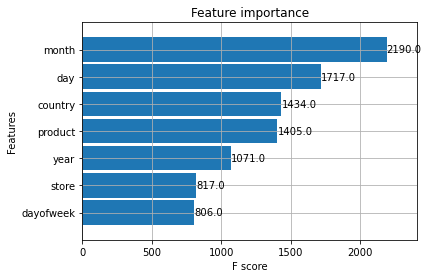

In [106]:
plot_importance(xgb, height=0.9)

In [107]:
cat_1 = CatBoostRegressor(verbose = 0, random_state = 42)
cat_1.fit(X_train, y_train)

In [108]:
vot = VotingRegressor(estimators=[('cat', cat_1), ('xgb', xgb), ('lgbm', lgbm)])
vot.fit(X_train, y_train)

VotingRegressor(estimators=[('cat',
                             <catboost.core.CatBoostRegressor object at 0x000002A79D31C400>),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=No...
                                          learning_rate=0.300000012,
                                          max_bin=256, max_cat_to_onehot=4,
                                          max_delta_step=0, max_depth=6,
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=150, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, ...)),
                            ('lgbm',
                             LGBMRegressor(application='regression',
                                           n_estimators=150,
                                           random_state=42))])

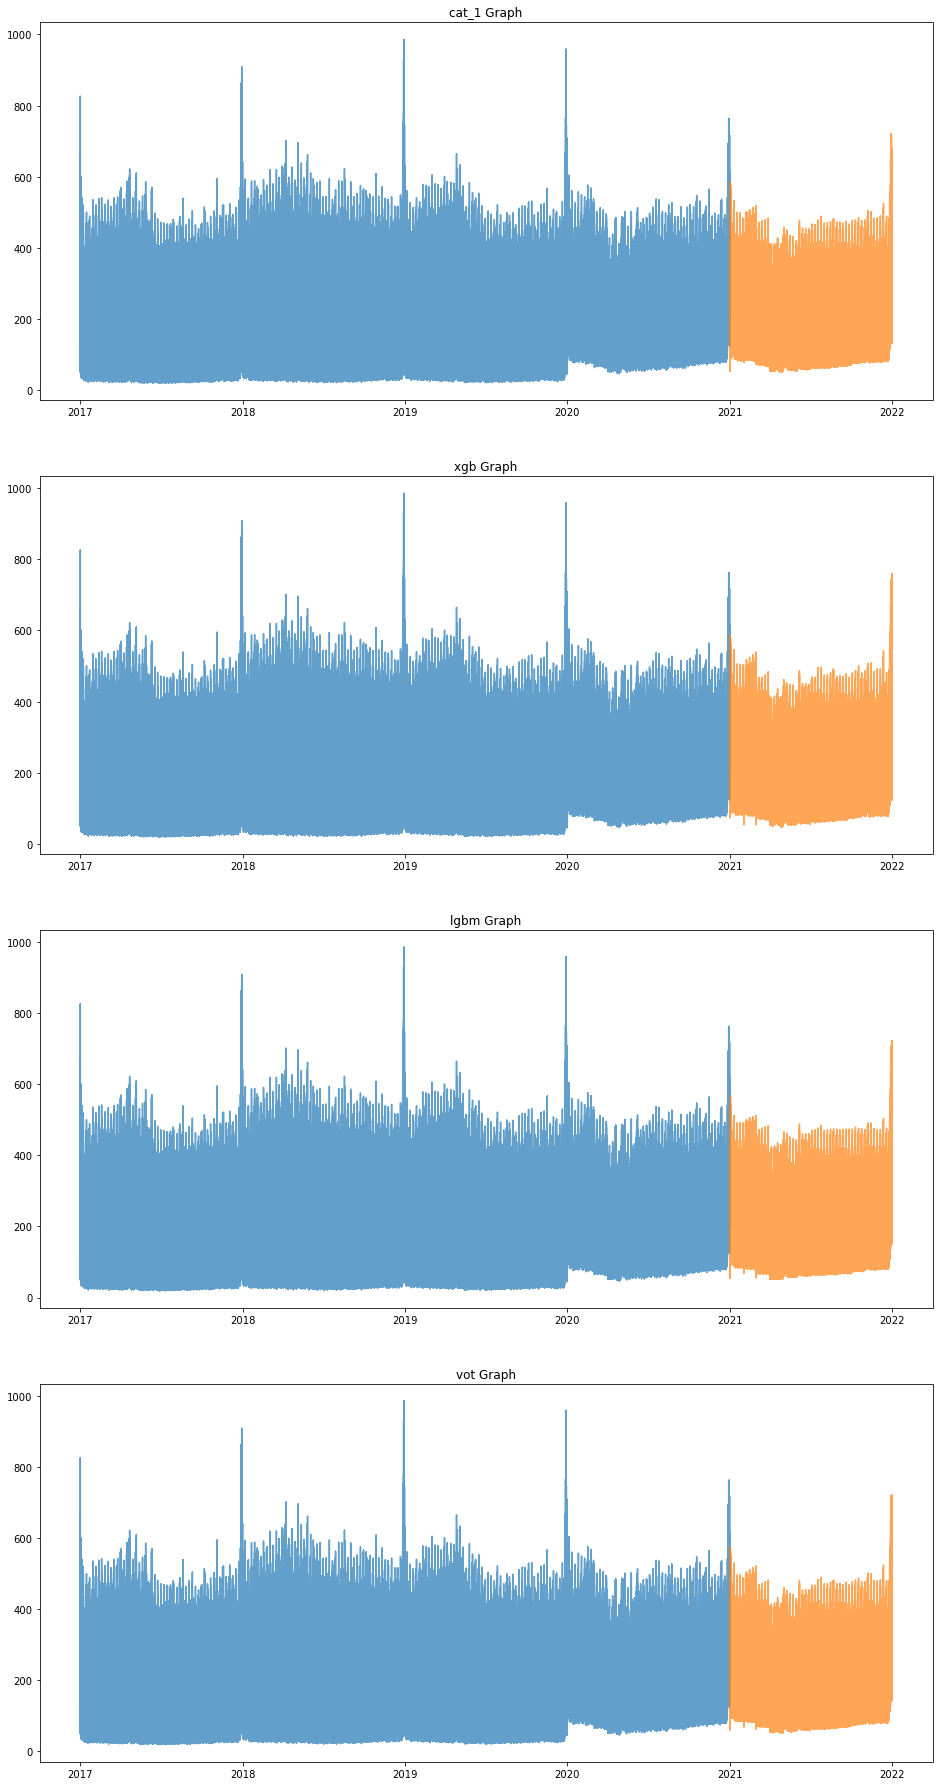

In [109]:
import matplotlib.pyplot as plt
cat_plot = cat_1.predict(test_drop)
xgb_plot = xgb.predict(test_drop)
lgbm_plot = lgbm.predict(test_drop)
vot_plot = vot.predict(test_drop)


plt.figure(figsize=(16,32))

plt.subplot(4, 1, 1)
plt.title('cat_1 Graph')
plt.plot(train['date'], y_train, test['date'], cat_plot, alpha = 0.7)

plt.subplot(4, 1, 2)
plt.title('xgb Graph')
plt.plot(train['date'], y_train, test['date'], xgb_plot, alpha = 0.7)

plt.subplot(4, 1, 3)
plt.title('lgbm Graph')
plt.plot(train['date'], y_train, test['date'], lgbm_plot, alpha = 0.7)

plt.subplot(4, 1, 4)
plt.title('vot Graph')
plt.plot(train['date'], y_train, test['date'], vot_plot, alpha = 0.7)
plt.show()

In [110]:
from sklearn.model_selection import cross_val_predict
print(cross_val_predict(cat_1, X_train, y_train, cv = 5).mean())
print(cross_val_predict(xgb, X_train, y_train, cv = 5).mean())
print(cross_val_predict(lgbm, X_train, y_train, cv = 5).mean())
print(cross_val_predict(vot, X_train, y_train, cv = 5).mean())

194.3012658345072
193.77687
193.5915674795427
193.88989649995926


In [111]:
# cross_val_predict(cat_2, X_train, y_train, cv = 10).mean()

In [112]:
# test_cate

In [113]:
predictions_1 = cat_1.predict(test_drop)
predictions_2 = xgb.predict(test_drop)
predictions_3 = lgbm.predict(test_drop)
predictions_4 = vot.predict(test_drop)
# predictions_2 = cat_2.predict(test_cate)

In [114]:
predictions_1

array([513.27130647, 413.6404031 , 365.56052815, ..., 170.64973478,
       145.37225435, 225.65943466])

In [115]:
predictions_2

array([510.30182, 420.24216, 362.55313, ..., 139.27776, 123.26744,
       201.01575], dtype=float32)

In [116]:
predictions_3

array([480.49699114, 372.53179627, 330.68293641, ..., 191.70324492,
       165.20368948, 237.85985877])

In [117]:
predictions_4

array([501.35670549, 402.13811878, 352.93219856, ..., 167.21024515,
       144.61446154, 221.51168017])

In [118]:
# predictions_2

In [119]:
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': predictions_4})
output.to_csv('cat_xgb_lgbm.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
